## **IPL Player Performance & Role-Clustering — Project Summary**

### **Name**: Soham Pal
### **Roll Number**: B2024117

### **Dataset:** IPL ball-by-ball (deliveries_updated_ipl_upto_2025.csv) and match-level (matches_updated_ipl_upto_2025.csv) data covering 2008–2025.

### **Goal:** Build a reproducible pipeline to evaluate individual player performance (batting + bowling), create interpretable aggregates (runs, dismissals, strike rate, economy, wickets, overs, etc.), and cluster players into meaningful cricket roles (e.g., Anchors, Power Hitters, Strike Bowlers, Death Specialists, All-Rounders) using unsupervised learning.

## Workflow (high level):

**Data cleaning & harmonization** — normalize team names, parse dates, handle missing/NA values, ensure wides/no-balls and dismissal fields are interpreted correctly.

**Player aggregation (from scratch)** — compute per-player batting aggregates (matches, total runs, balls faced, fours, sixes, dismissals → batting average, strike rate) and bowling aggregates (balls bowled, overs, runs conceded, wickets, economy, bowling average). All aggregates are derived directly from deliveries to avoid mixing precomputed/incorrect statistics.

**Feature engineering** — add derived metrics (boundary rate, bowling strike rate, all-rounder index, MVP score, phase-specific metrics like powerplay/death performance). Filter to players with reasonable samples (e.g., ≥20 matches).

**Exploratory analysis & visualizations** — season trends, result distributions, top run/wicket scorers, Avg vs SR scatter, Economy vs Wickets scatter, distributions, and time-series trends for selected players.

**Clustering** — standardize features, evaluate k using Elbow + Silhouette, run K-Means, and produce cluster summaries. Although statistical evaluation often suggests k≈4–5, domain needs motivate k=6 (recommended) for richer role separation; k can be changed easily.

**Labeling & interpretation** — map clusters to cricket roles via cluster signatures (avg runs, wickets, SR, economy, all-rounder index) and produce PCA and radar visualizations to explain cluster shapes.

**Deliverables** — labeled player table (player, aggregates, cluster, final_role), cluster_summary table, PCA + radar plots, top-10 lists per role, and CSV exports for reporting/Power BI.

## Key decisions & rationale:

- All per-player statistics are computed from ball-by-ball records to ensure correctness (dismissals counted only when player_dismissed == batsman; wides/no-balls excluded where appropriate).

- We evaluate clustering both statistically (Elbow, Silhouette) and domain-wise (do clusters reflect cricket roles). For this dataset, k = 7 is chosen as the best trade-off between statistical validity and cricket interpretability (yields: Elite All-Phase Batters, Power Hitters/Finishers, Anchors, Strike Bowlers, Death Specialists, All-Rounders).

- Clusters are labeled using interpretable thresholds and domain knowledge.

In [210]:
import warnings
warnings.filterwarnings("ignore")

# Standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from math import sqrt

In [211]:
#Loading Match data set 
df_match= pd.read_csv("C:\\Users\\HP\\Downloads\\matches_updated_ipl_upto_2025.csv")
df_match.head()

,season,venue,event,result,result_margin,target_runs,winner_runs,umpire2,toss_winner,date,...,team2,balls_per_over,winner_wickets,tv_umpire,player_of_match,match_referee,outcome,date2,match_number,matchId
0,2007/08,M Chinnaswamy Stadium,Indian Premier League,runs,140.0,223.0,140.0,RE Koertzen,Royal Challengers Bangalore,18-04-2008,...,Kolkata Knight Riders,6,NaN,AM Saheba,BB McCullum,J Srinath,NaN,NaN,1.0,335982
1,2007/08,"Punjab Cricket Association Stadium, Mohali",Indian Premier League,runs,33.0,241.0,33.0,SL Shastri,Chennai Super Kings,19-04-2008,...,Chennai Super Kings,6,NaN,RB Tiffin,MEK Hussey,S Venkataraghavan,NaN,NaN,2.0,335983
2,2007/08,Feroz Shah Kotla,Indian Premier League,wickets,9.0,130.0,NaN,GA Pratapkumar,Rajasthan Royals,19-04-2008,...,Rajasthan Royals,6,9.0,IL Howell,MF Maharoof,GR Viswanath,NaN,NaN,3.0,335984
3,2007/08,Eden Gardens,Indian Premier League,wickets,5.0,166.0,NaN,K Hariharan,Deccan Chargers,20-04-2008,...,Deccan Chargers,6,5.0,Asad Rauf,DJ Hussey,FM Engineer,NaN,NaN,4.0,335986
4,2007/08,Wankhede Stadium,Indian Premier League,wickets,5.0,111.0,NaN,DJ Harper,Mumbai Indians,20-04-2008,...,Royal Challengers Bangalore,6,5.0,AV Jayaprakash,MV Boucher,J Srinath,NaN,NaN,5.0,335985


In [212]:
#Loading Deliveries data set 
df_del= pd.read_csv("C:\\Users\\HP\\Downloads\\deliveries_updated_ipl_upto_2025.csv")
df_del.head()

,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,...,extras,isWide,isNoBall,Byes,LegByes,Penalty,is_wicket,dismissal_kind,player_dismissed,date
0,335982,1,0.1,0,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,...,1,NaN,NaN,NaN,1.0,NaN,0,NaN,NaN,18-04-2008
1,335982,1,0.2,0,2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,...,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,18-04-2008
2,335982,1,0.3,0,3,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,...,1,1.0,NaN,NaN,NaN,NaN,0,NaN,NaN,18-04-2008
3,335982,1,0.4,0,4,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,...,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,18-04-2008
4,335982,1,0.5,0,5,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,...,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,18-04-2008


In [213]:
df_del.info() #Checking data info of Delivery data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278205 entries, 0 to 278204
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   matchId           278205 non-null  int64  
 1   inning            278205 non-null  int64  
 2   over_ball         278205 non-null  float64
 3   over              278205 non-null  int64  
 4   ball              278205 non-null  int64  
 5   batting_team      278205 non-null  object 
 6   bowling_team      278205 non-null  object 
 7   batsman           278205 non-null  object 
 8   non_striker       278205 non-null  object 
 9   bowler            278205 non-null  object 
 10  batsman_runs      278205 non-null  int64  
 11  extras            278205 non-null  int64  
 12  isWide            9080 non-null    float64
 13  isNoBall          1163 non-null    float64
 14  Byes              701 non-null     float64
 15  LegByes           4215 non-null    float64
 16  Penalty           2 

In [214]:
df_del.duplicated().sum()  #Checking duplicate rows

np.int64(3)

In [215]:
df_match.info() #Checking data info of Match 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1169 entries, 0 to 1168
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           1169 non-null   object 
 1   venue            1169 non-null   object 
 2   event            1169 non-null   object 
 3   result           1169 non-null   object 
 4   result_margin    1150 non-null   float64
 5   target_runs      1165 non-null   float64
 6   winner_runs      531 non-null    float64
 7   umpire2          1169 non-null   object 
 8   toss_winner      1169 non-null   object 
 9   date             1169 non-null   object 
 10  neutralvenue     77 non-null     object 
 11  umpire1          1169 non-null   object 
 12  city             1118 non-null   object 
 13  reserve_umpire   1145 non-null   object 
 14  winner           1146 non-null   object 
 15  eliminator       15 non-null     object 
 16  date1            2 non-null      object 
 17  method        

## Data Cleaning, Preprocessing, Standardization

In [216]:
df_match.duplicated().sum()  #Checking duplicate rows

np.int64(0)

In [217]:
#checking city columns with venue columns so that, i can identify the location and fill a/c where value is NaN 
df_match[df_match['city'].isna()]['venue'].unique()

array(['Sharjah Cricket Stadium', 'Dubai International Cricket Stadium'],
      dtype=object)

In [218]:
# Filling missing city values based on venue
df_match.loc[(df_match['city'].isna()) & (df_match['venue'] == 'Sharjah Cricket Stadium'), 'city'] = 'Sharjah'
df_match.loc[(df_match['city'].isna()) & (df_match['venue'] == 'Dubai International Cricket Stadium'), 'city'] = 'Dubai'
df_match['city'].isnull().sum()  #Checking if missing values are filled or not

np.int64(0)

In [219]:
#replacing season in correct format
df_match.replace({'season': {"2020/21": "2020", "2009/10": "2010", "2007/08": "2008"}}, inplace=True)

In [220]:
#Replacing Team old name to new name 
team_map ={"Mumbai Indians":"Mumbai Indians",
          "Chennai Super Kings":"Chennai Super Kings",
          "Kolkata Knight Riders":"Kolkata Knight Riders",
          "Royal Challengers Bangalore":"Royal Challengers Bangalore",
          "Royal Challengers Bengaluru":"Royal Challengers Bangalore",
          "Rajasthan Royals":"Rajasthan Royals",
          "Kings XI Punjab":"Kings XI Punjab",
          "Punjab Kings":"Kings XI Punjab",
          "Sunrisers Hyderabad":"Sunrisers Hyderabad",
          "Deccan Chargers":"Sunrisers Hyderabad",
          "Delhi Capitals":"Delhi Capitals",
          "Delhi Daredevils":"Delhi Capitals",
          "Gujarat Titans":"Gujarat Titans",
          "Gujarat Lions":"Gujarat Titans",
          "Lucknow Super Giants":"Lucknow Super Giants",
          "Pune Warriors":"Pune Warriors",
          "Rising Pune Supergiant":"Pune Warriors",
          "Rising Pune Supergiants":"Pune Warriors",
          "Kochi Tuskers Kerala":"Kochi Tuskers Kerala"}

#For Match table 
df_match['team1']= df_match['team1'].map(team_map)
df_match['team2']= df_match['team2'].map(team_map)
df_match['winner']= df_match['winner'].map(team_map)
df_match['toss_winner']= df_match['toss_winner'].map(team_map)

#For Deliverise Tables 
df_del['batting_team']= df_del['batting_team'].map(team_map)
df_del['bowling_team']= df_del['bowling_team'].map(team_map)

# **Exploratory Data Analysis**

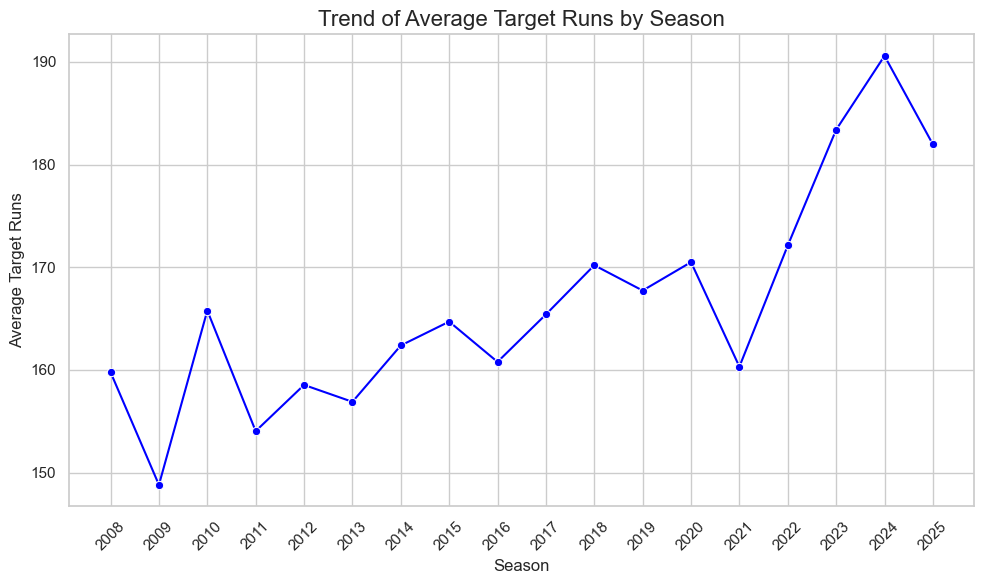

In [221]:
# avg target run by season 
avg_run_byseason = pd.pivot_table(data=df_match, index='season', values='target_runs', aggfunc='mean')
avg_run_byseason.reset_index(inplace=True)

# Creating line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_run_byseason, x='season', y='target_runs', marker='o', color='blue')

# Adding titles and labels
plt.title('Trend of Average Target Runs by Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Target Runs', fontsize=12)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

## 📌 **1. Trend of Average Target Runs by Season**

* IPL scoring has shown a **clear upward trend**, especially from **2021 onwards**, where targets have consistently crossed 175+.
* The peak around **2024** reflects the era of high-scoring pitches, batting depth, and aggressive batting strategies across teams.
* Early IPL seasons (2008–2013) were relatively low-scoring (~155–165), but modern seasons routinely see **180+ targets**, indicating a shift toward **power-hitting and batting-friendly conditions**.

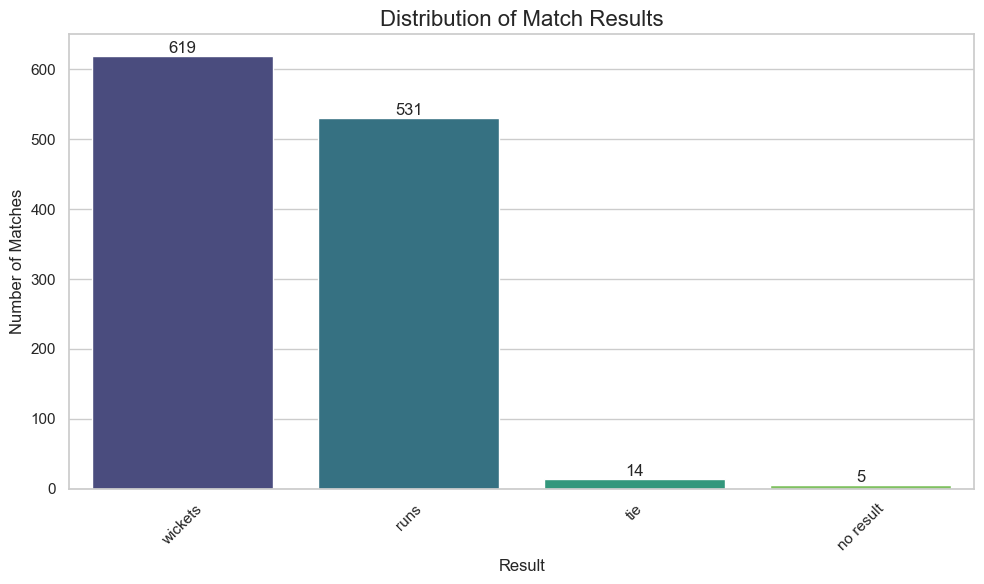

In [222]:
# Distribution of Match Results
result_distribution = df_match['result'].value_counts()

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=result_distribution.index, y=result_distribution.values, palette='viridis')

# Adding titles and labels
plt.title('Distribution of Match Results', fontsize=16)
plt.xlabel('Result', fontsize=12)
plt.ylabel('Number of Matches', fontsize=12)

# Showing the values on top of the bars
for index, value in enumerate(result_distribution):
    plt.text(index, value, f'{value}', ha='center', va='bottom')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

## 📌 **2. Distribution of Match Results**

* Most matches are won by **wickets (619)** or **runs (531)**, showing a fairly balanced contest between chasing and defending teams.
* **Ties (14)** and **no-results (5)** are extremely rare, reaffirming IPL’s strong result consistency.
* Slight edge toward **chasing success**, but not overwhelmingly — strategic bowling at the death still keeps defending competitive.

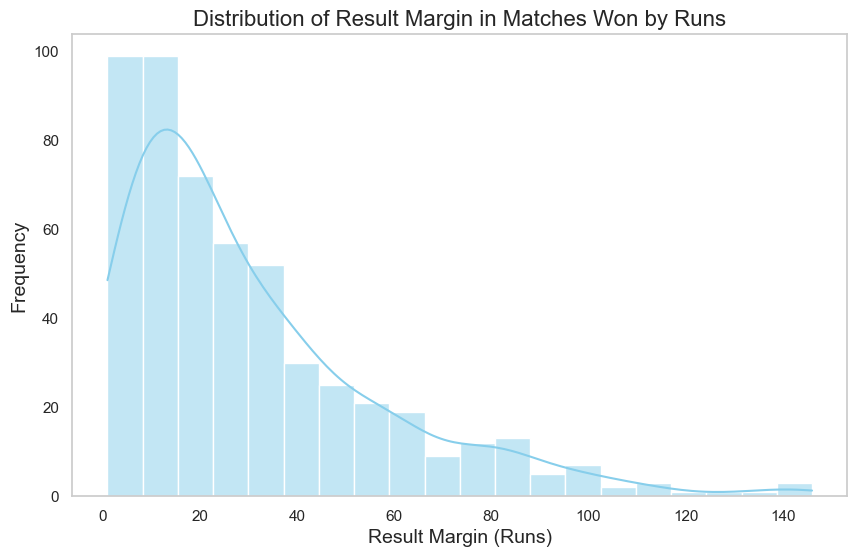

In [223]:
# distribution of results won by runs
runs_margin = df_match[df_match['result'] == 'runs']['result_margin']

# Ploting the distribution of result margins using histogram 
plt.figure(figsize=(10, 6))
sns.histplot(runs_margin, bins=20, kde=True, color='skyblue')

# Adding titles and labels
plt.title('Distribution of Result Margin in Matches Won by Runs', fontsize=16)
plt.xlabel('Result Margin (Runs)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid()
plt.show()

## 📌 **3. Result Margin Distribution (Matches Won by Runs)**

* Most run victories fall within the **10–40 run** margin, showing that defending teams usually win by **moderate but competitive margins**.
* Very large victories (>70 runs) are rare, indicating that **one-sided matches are uncommon** in the IPL.
* The long tail in the distribution suggests occasional blowouts when pitches favor bowlers or chasing teams collapse.

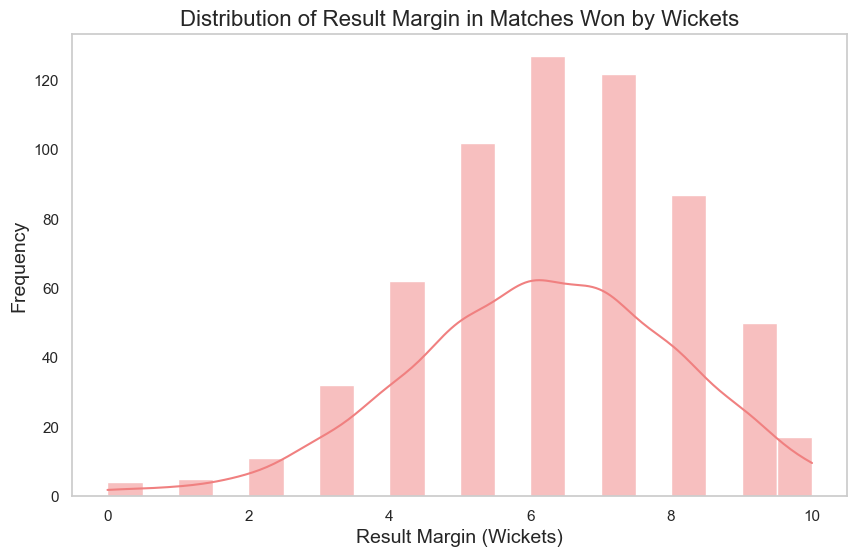

In [224]:
# distribution of results won by wickets
wickets_margin = df_match[df_match['result'] == 'wickets']['result_margin']

# Plot the distribution of result margins using histogram
plt.figure(figsize=(10, 6))
sns.histplot(wickets_margin, bins=20, kde=True, color='lightcoral')

# Adding titles and labels
plt.title('Distribution of Result Margin in Matches Won by Wickets', fontsize=16)
plt.xlabel('Result Margin (Wickets)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid()
plt.show()

## 📌 **4. Result Margin Distribution (Matches Won by Wickets)**

* Most chasing victories happen by **6–8 wickets**, showing that successful chases often appear comfortable on the scorecard.
* Wins by **1–3 wickets** are less frequent, indicating fewer nail-biters than expected.
* This distribution highlights that when teams chase successfully, they often do so with decent batting depth remaining.

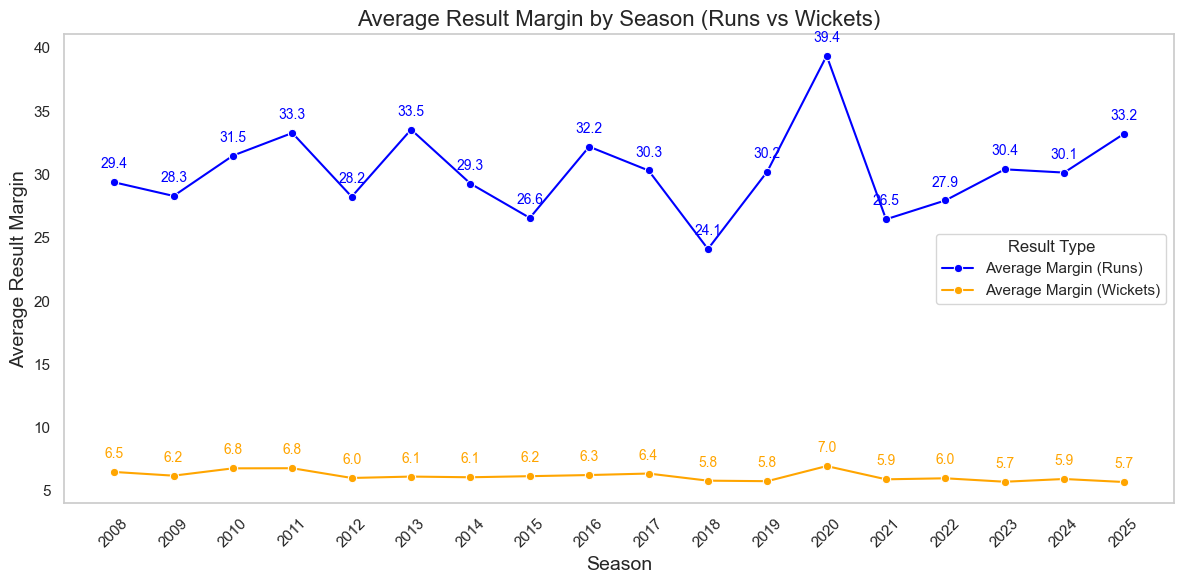

In [225]:
# average result margin across seasons for both runs and wickets
result_margins = df_match[(df_match['result'] == 'runs') | (df_match['result'] == 'wickets')]

# Creating a pivot table for average result margins by season and result type
avg_result = pd.pivot_table(
    data=result_margins, 
    index='season', 
    columns='result', 
    values='result_margin', 
    aggfunc='mean'
)

# Resetting the index for plotting
avg_result.reset_index(inplace=True)

# Plotting the average result margins
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_result, x='season', y='runs', marker='o', label='Average Margin (Runs)', color='blue')
sns.lineplot(data=avg_result, x='season', y='wickets', marker='o', label='Average Margin (Wickets)', color='orange')

# Adding titles and labels
plt.title('Average Result Margin by Season (Runs vs Wickets)', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Result Margin', fontsize=14)
plt.legend(title='Result Type')

# Showing the values on markers
for index, row in avg_result.iterrows():
    plt.annotate(f'{row["runs"]:.1f}', 
                 (row['season'], row['runs']), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', fontsize=10, color='blue')
    
    plt.annotate(f'{row["wickets"]:.1f}', 
                 (row['season'], row['wickets']), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', fontsize=10, color='orange')

plt.grid()
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()


## 📌 **5. Average Result Margin by Season (Runs vs Wickets)**

* **Runs-based victory margins** fluctuate between **26–35**, with occasional highs (like ~39 in 2020), indicating seasons where **bowling units dominated** or pitches were two-paced.
* **Wicket-based margins** remain remarkably stable around **5–6 wickets**, suggesting long-term consistency in chasing patterns.
* Stability in wicket margins vs. variability in run margins implies:

  * **Chasing strategies are stable across years**, while
  * **Defending strategies and pitch conditions change more season-to-season**.

## 🌟 **Overall IPL EDA Summary**

* **Scoring has increased significantly** over the years — recent seasons feature more aggressive batting.
* Match outcomes show a **healthy balance** between batting first and chasing.
* Most matches are **competitively decided**, with only a small fraction being extreme blowouts.
* Chasing victories appear comfortable on the scorecard, but run-defense margins vary with pitch conditions.
* The consistency in wicket margins vs. variability in run margins provides strong context for team strategy and player role analysis later in the project.

# **Player Performance Evaluation**

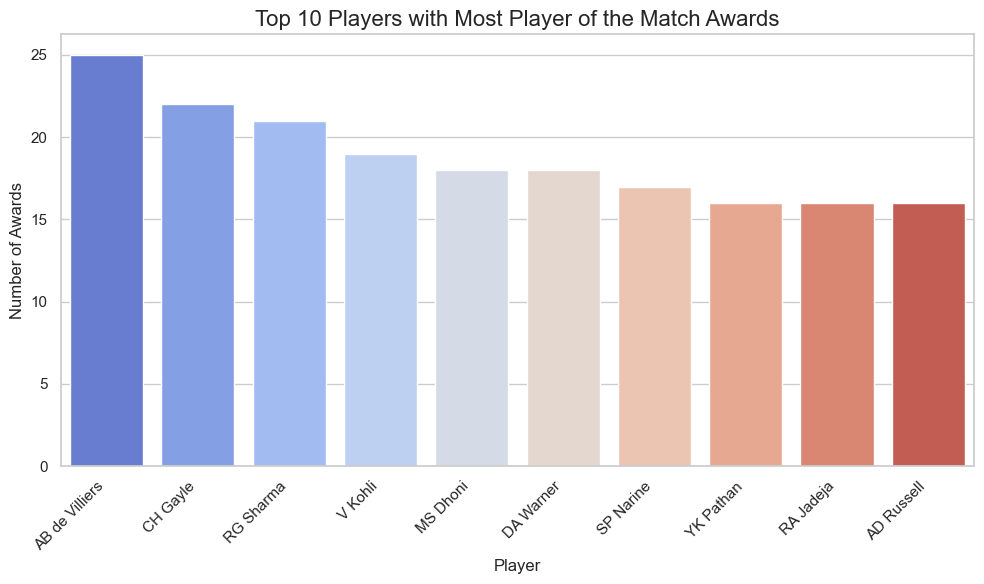

In [226]:
#players have won the most 'Player of the Match' awards
df_match['player_of_match'].value_counts().head() #Top 5 

# Ploting Top 10 Players with Most Player of the Match Awards
player_counts = df_match['player_of_match'].value_counts().head(10)  

# Creating a bar plot
plt.figure(figsize=(10, 6))  
sns.barplot(x=player_counts.index, y=player_counts.values, palette='coolwarm')

# Adding titles and labels
plt.title('Top 10 Players with Most Player of the Match Awards', fontsize=16)
plt.xlabel('Player', fontsize=12)
plt.ylabel('Number of Awards', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()  
plt.show()

## **🔍 Player of the Match Awards (Top 10)**

* **AB de Villiers leads the league** with the highest number of Player of the Match awards, highlighting his unmatched ability to single-handedly change games.
* **Chris Gayle and Rohit Sharma** follow closely, reflecting their long-term impact as explosive match-winners.
* **Virat Kohli, MS Dhoni, and David Warner** demonstrate consistent match-winning contributions through elite batting and leadership.
* **Sunil Narine, Yusuf Pathan, Ravindra Jadeja, and Andre Russell** show the high value of **all-round and power-hitting roles**, where contributions in multiple disciplines often swing results.
* Overall, this list captures players known for producing **high-impact, game-defining performances** rather than just cumulative stats.

## A. Batting Evaluation

          batsman  total_runs
0         V Kohli        8671
1       RG Sharma        7048
2        S Dhawan        6769
3       DA Warner        6567
4        SK Raina        5536
5        MS Dhoni        5439
6        KL Rahul        5235
7  AB de Villiers        5181
8       AM Rahane        5032
9        CH Gayle        4997


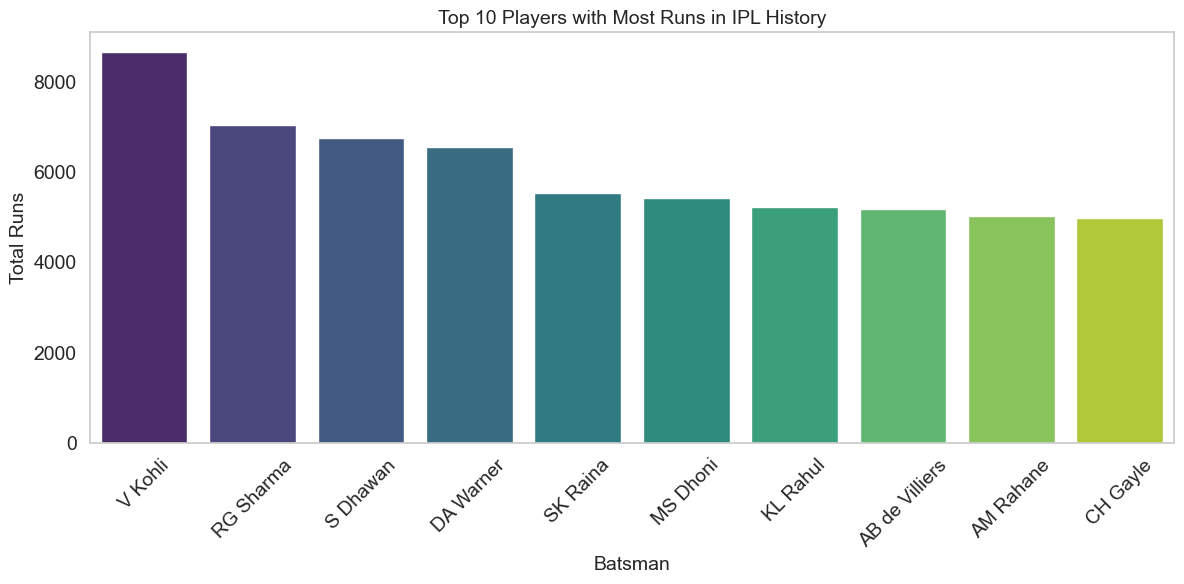

In [227]:
player_runs = df_del[['batsman', 'batsman_runs']]
player_runs = player_runs.groupby('batsman')['batsman_runs'].sum().reset_index(name='total_runs')

# Sorting the players by total runs
top_players = player_runs.sort_values(by='total_runs', ascending=False).head(10)

print(top_players.reset_index(drop=True))

# Plotting the data
plt.figure(figsize=(12, 6))  
bar_plot = sns.barplot(data=top_players, x='batsman', y='total_runs', palette='viridis')

# # Adding titles and labels
plt.title('Top 10 Players with Most Runs in IPL History', fontsize=14)
plt.xlabel('Batsman', fontsize=14)
plt.ylabel('Total Runs', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## **1. Top 10 Players with Most Runs in IPL History**

* **Virat Kohli dominates** IPL run-scoring with a significant lead, reaffirming his role as the tournament’s most consistent batter.
* Rohit Sharma, Shikhar Dhawan, and David Warner complete the **core group of long-term consistent run accumulators**.
* MS Dhoni and AB de Villiers show up despite batting lower or finishing roles, highlighting their **high-impact contribution**.
* All players in the top 10 have played **long careers**, meaning these rankings reflect longevity + consistency.

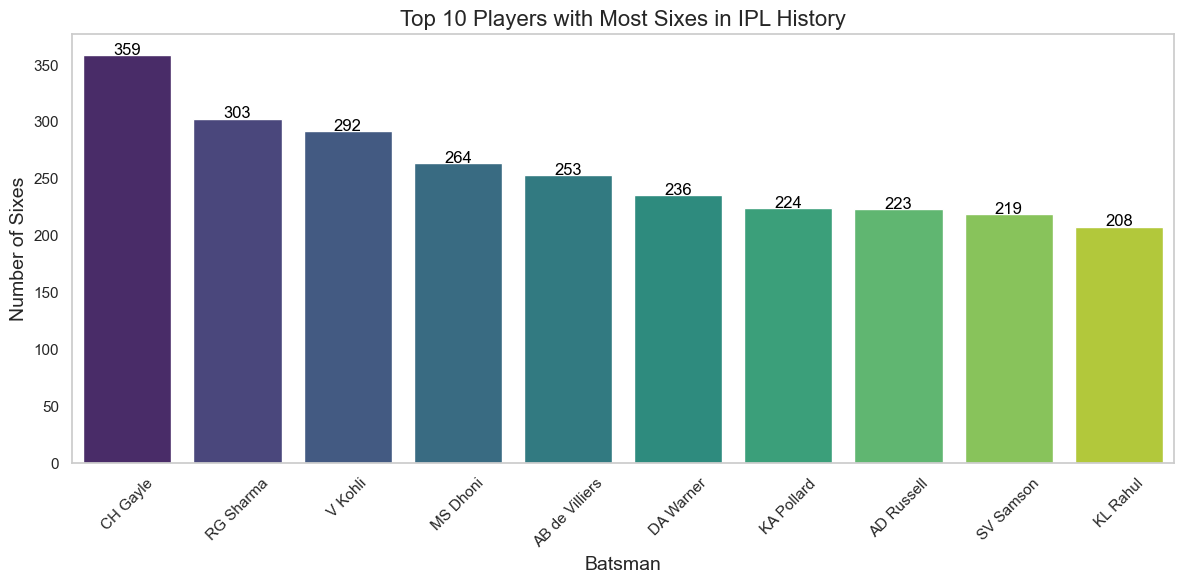

In [228]:
most_sixes = df_del[df_del['batsman_runs'] == 6]['batsman'].value_counts().head(10)
most_sixes_df = most_sixes.reset_index()
most_sixes_df.columns = ['batsman', 'sixes']

# Plotting the data
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=most_sixes_df, x='batsman', y='sixes', palette='viridis')
for index, row in most_sixes_df.iterrows():
    bar_plot.text(index, row.sixes + 0.1, row.sixes, color='black', ha="center", fontsize=12)

# Adding titles and labels
plt.title('Top 10 Players with Most Sixes in IPL History', fontsize=16)
plt.xlabel('Batsman', fontsize=14)
plt.ylabel('Number of Sixes', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## **2. Top 10 Players with Most Sixes**

* **Chris Gayle is in a league of his own**, with a six-hitting tally far above everyone else—true power-hitting benchmark.
* Rohit Sharma and Virat Kohli follow, showing they balance consistency with boundary-hitting.
* Heavy hitters like Pollard, Russell, and Sanju Samson reinforce the dominance of **middle-order finishers** in T20 cricket.

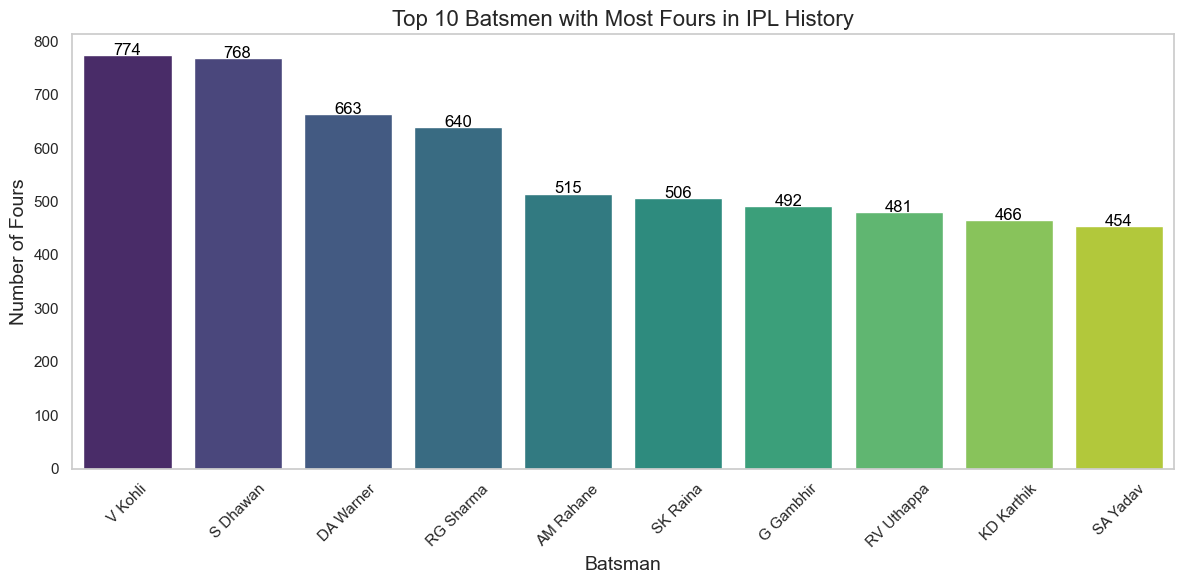

In [229]:
most_fours = df_del[df_del['batsman_runs'] == 4]['batsman'].value_counts().head(10)
most_fours_df = most_fours.reset_index()
most_fours_df.columns = ['batsman', 'fours']

# Plotting the data
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=most_fours_df, x='batsman', y='fours', palette='viridis')
for index, row in most_fours_df.iterrows():
    bar_plot.text(index, row.fours + 0.1, row.fours, color='black', ha="center", fontsize=12)

# Adding titles and labels
plt.title('Top 10 Batsmen with Most Fours in IPL History', fontsize=16)
plt.xlabel('Batsman', fontsize=14)
plt.ylabel('Number of Fours', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## **3. Top 10 Batsmen with Most Fours**

* Virat Kohli and Shikhar Dhawan again top the charts, showing their **classical, ground-based batting style**.
* David Warner and Rohit Sharma appear in both fours & sixes lists → **complete aggressive openers**.
* Players like Gambhir, Uthappa, and Raina highlight the era of **anchoring top-order batsmen**.

In [230]:
# Objective: Highest batting average = total runs / number of dismissals

# Relevant columns
batter_data = df_del[['matchId','batsman','batsman_runs']]

# 1. Matches played by each batsman
batter_matches = (
    batter_data.groupby('batsman')['matchId']
    .nunique()
    .reset_index(name='matches_played')
)

# 2. Total runs scored
batter_total_runs = (
    batter_data.groupby('batsman')['batsman_runs']
    .sum()
    .reset_index(name='total_runs')
)

# 3. Number of times batsman got OUT
batter_outs = (
    df_del[df_del['player_dismissed'].notna()]
    .groupby('player_dismissed')['player_dismissed']
    .count()
    .reset_index(name='times_out')
    .rename(columns={'player_dismissed':'batsman'})
)

# 4. Merge all
batter_summary = (
    batter_matches
    .merge(batter_total_runs, on='batsman', how='left')
    .merge(batter_outs, on='batsman', how='left')
)

# 5. Handle missing dismissals (players never dismissed → set to NaN)
batter_summary['times_out'] = batter_summary['times_out'].replace(0, np.nan)

# 6. Correct batting average formula
batter_summary['batting_average'] = batter_summary['total_runs'] / batter_summary['times_out']

# 7. Filter only meaningful players (played minimum 40 matches)
batter_summary = batter_summary[batter_summary['matches_played'] >= 40]

# 8. Sort by batting average
batter_summary = (
    batter_summary.sort_values('batting_average', ascending=False)
    .reset_index(drop=True)
)

batter_summary


,batsman,matches_played,total_runs,times_out,batting_average
0,B Sai Sudharsan,40,1793,36.0,49.805556
1,KL Rahul,135,5235,115.0,45.521739
2,RD Gaikwad,70,2502,62.0,40.354839
3,DA Warner,184,6567,164.0,40.042683
4,H Klaasen,45,1480,37.0,40.000000
...,...,...,...,...,...
126,R Vinay Kumar,42,310,28.0,11.071429
127,UT Yadav,48,208,21.0,9.904762
128,HV Patel,41,270,29.0,9.310345
129,P Kumar,57,340,38.0,8.947368


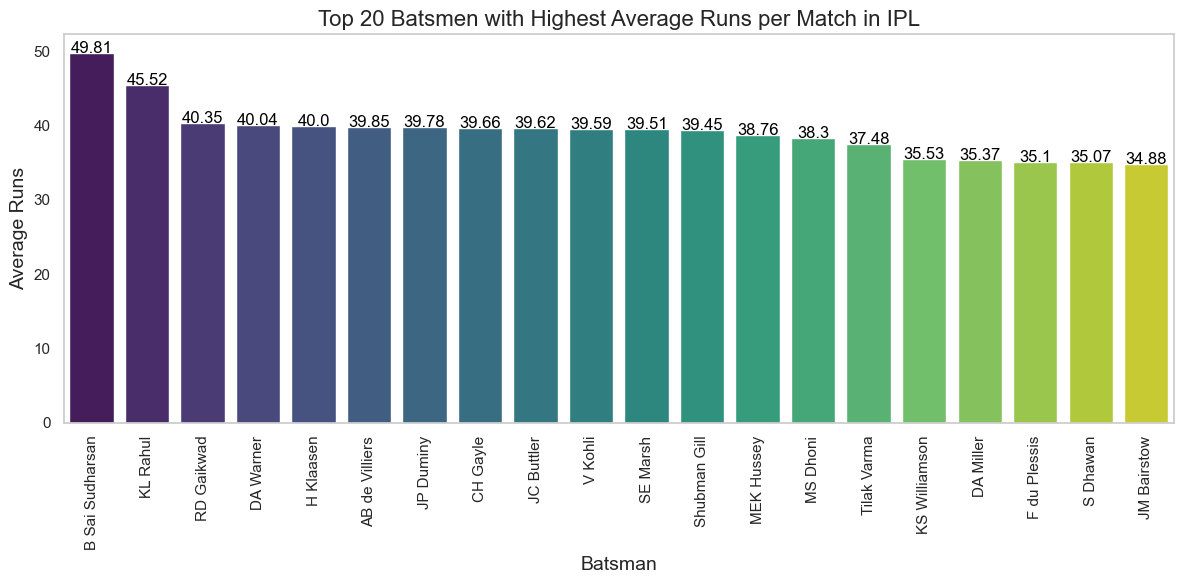

In [231]:
#Plotting the data for top 20 batsmen with the highest average runs
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=batter_summary.head(20), x='batsman', y='batting_average', palette='viridis')

#Annotating the bars with average runs
for index, row in batter_summary.head(20).iterrows():
    bar_plot.text(index, row.batting_average, round(row.batting_average, 2), color='black', ha="center")
# Adding titles and labels
plt.title('Top 20 Batsmen with Highest Average Runs per Match in IPL', fontsize=16)
plt.xlabel('Batsman', fontsize=14)
plt.ylabel('Average Runs', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## **4. Top 20 Batsmen with Highest Average Runs per Match**

* **B Sai Sudharsan** surprisingly tops averages, indicating an excellent early-career consistency.
* KL Rahul continues his reputation as one of the **most reliable modern IPL batters**.
* Big names like ABD, Warner, Gayle, Kohli show balance between **high-scoring ability + match consistency**.
* Many modern players (Gill, Varman, Klaasen) indicate **recent rise of technically strong T20 batsmen**.

In [232]:
# top batsmen with highest strike rate in IPL history (min 200 balls faced)
batter_data= df_del[['batsman','batsman_runs','ball']]  # Filtering Relevent Data   
batter_summary= batter_data.groupby('batsman').agg({'batsman_runs':'sum','ball':'count'}).reset_index()
batter_summary['strike_rate'] = (batter_summary['batsman_runs'] / batter_summary['ball']) * 100
batter_summary= batter_summary[batter_summary['ball']>=200]  # Filtering batsmen with min 200 balls faced
batter_strike_rate= batter_summary.sort_values(by='strike_rate', ascending=False).reset_index(drop=True)
batter_strike_rate.head(20)


,batsman,batsman_runs,ball,strike_rate
0,J Fraser-McGurk,385,203,189.655172
1,Priyansh Arya,545,310,175.806452
2,Naman Dhir,392,226,173.451327
3,PD Salt,1056,623,169.502408
4,AD Russell,2655,1626,163.284133
5,H Klaasen,1480,907,163.175303
6,TM Head,1146,706,162.322946
7,TH David,846,524,161.450382
8,T Stubbs,711,442,160.859729
9,N Pooran,2293,1433,160.013957


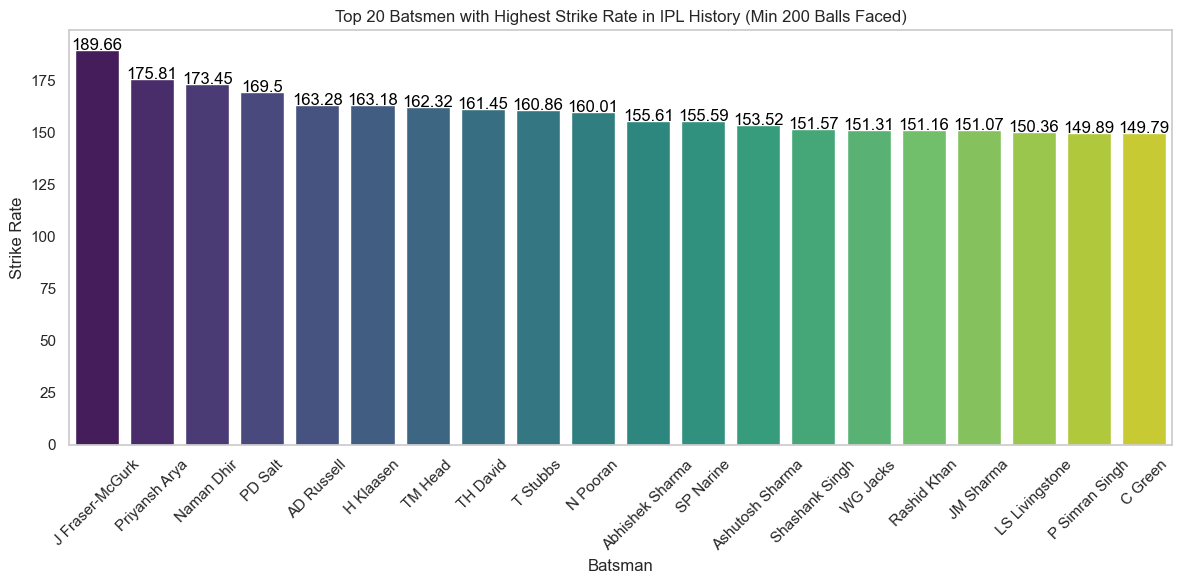

In [233]:
#Plotting the data for top 20 batsmen with the highest strike rate
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=batter_strike_rate.head(20), x='batsman', y='strike_rate', palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 20 Batsmen with Highest Strike Rate in IPL History (Min 200 Balls Faced)')
plt.xlabel('Batsman')
plt.ylabel('Strike Rate')

# Annotating the bars with strike rates
for index, row in batter_strike_rate.head(20).iterrows():   
    bar_plot.text(index, row.strike_rate, round(row.strike_rate, 2), color='black', ha="center")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## **5. Top 20 Batsmen with Highest Strike Rate (Min 200 Balls)**

* Fraser-McGurk leads with an explosive strike rate near **190**, showing new-age ultra-aggressive hitting.
* Priyansh Arya, Naman Dhir and Tim David reflect the rise of **young Indian & overseas finishers**.
* Russell, Narine, Pooran are consistent T20 power hitters, validating the **finisher's impact in IPL**.
* Strike-heavy players often face **limited balls**, but maximize impact in finishing roles.

In [234]:
# Filtering data for final overs (overs 16 to 20)
final_overs_data = df_del[(df_del['over'] >= 16) & (df_del['over'] < 20)]

# Calculating runs and balls faced by each batsman in the death overs
batsman_stats = final_overs_data.groupby('batsman').agg(
    runs_scored=('batsman_runs', 'sum'),
    balls_faced=('ball', 'count')
).reset_index()

# Filtering batsmen who have faced at least 150 balls for dare comparison 
batsman_stats = batsman_stats[batsman_stats['balls_faced'] >= 150]

# Calculating strike rate
batsman_stats['strike_rate'] = (batsman_stats['runs_scored'] / batsman_stats['balls_faced']) * 100

# Sorting by strike rate in descending order
top_strike_rates = batsman_stats.sort_values(by='strike_rate', ascending=False).reset_index(drop=True)

# Displaying the top batsmen with the highest strike rates in final overs
top_15_strike_rates = top_strike_rates.head(15)

top_15_strike_rates

,batsman,runs_scored,balls_faced,strike_rate
0,T Stubbs,370,154,240.259740
1,AB de Villiers,1421,635,223.779528
2,H Klaasen,434,217,200.000000
3,Shashank Singh,360,181,198.895028
4,RR Pant,696,356,195.505618
5,CH Gayle,404,209,193.301435
6,V Kohli,1121,586,191.296928
7,JH Kallis,303,159,190.566038
8,F du Plessis,416,220,189.090909
9,SS Iyer,513,273,187.912088


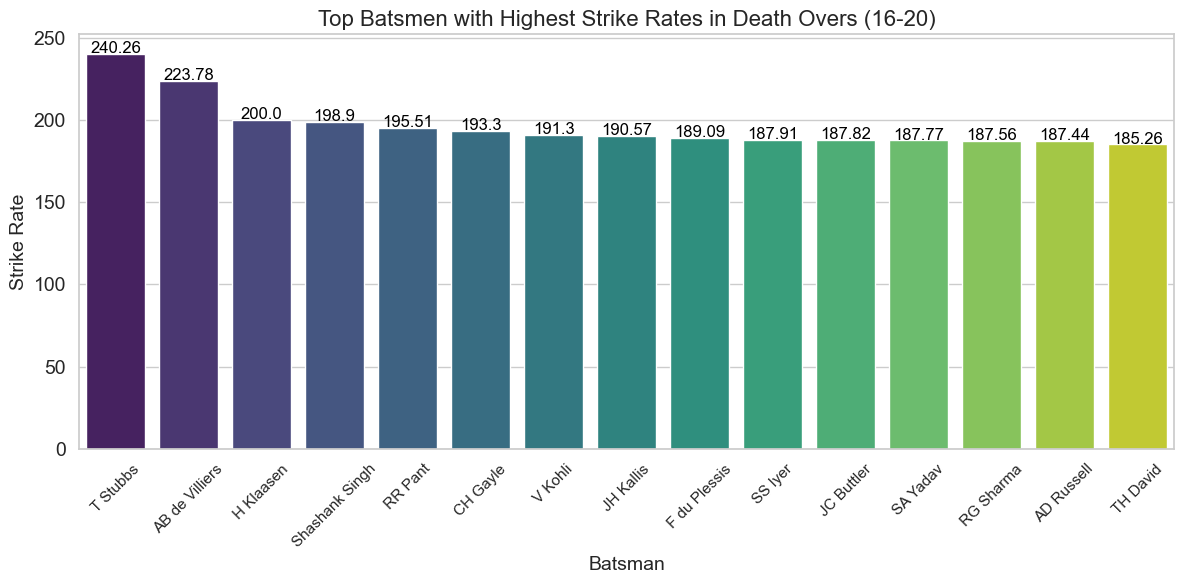

In [235]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_15_strike_rates, x='batsman', y='strike_rate', palette='viridis')

# Adding title and labels
plt.title('Top Batsmen with Highest Strike Rates in Death Overs (16-20)', fontsize=16)
plt.xlabel('Batsman', fontsize=14)
plt.ylabel('Strike Rate', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
# Adding value on top of bars
for index, row in top_15_strike_rates.iterrows():
    plt.text(index, row['strike_rate'] + 0.5, round(row['strike_rate'], 2), color='black', ha='center')

plt.tight_layout()
plt.show()

## **6. Top Batsmen Strike Rates in Death Overs (16–20)**

* **Tristan Stubbs** leads with a strike rate above **240**, showcasing exceptional finishing.
* ABD remains one of the best finishers in IPL history.
* RR Pant, Gayle, Kohli, Kallis show historical dominance in closing out games.
* Finishers show **explosive numbers**, indicating the importance of specialized death-overs skill.

In [236]:
# Filtering for the first 6 overs
powerplay_data = df_del[df_del['over'] < 6]

# Calculating total runs and balls faced by each batsman
batsman_stats = powerplay_data.groupby('batsman').agg(
    total_runs=pd.NamedAgg(column='batsman_runs', aggfunc='sum'),
    balls_faced=pd.NamedAgg(column='ball', aggfunc='count')
).reset_index()

# Calculating strike rate
batsman_stats['strike_rate'] = (batsman_stats['total_runs'] / batsman_stats['balls_faced']) * 100

# Filtering batsmen who faced at least 150 balls for fare comparison 
batsman_stats = batsman_stats[batsman_stats['balls_faced'] >= 150]

# Sorting by strike rate
top_strike_rates_powerplay = batsman_stats.sort_values(by='strike_rate', ascending=False).reset_index(drop=True)

# Display the top batsmen with the highest strike rates in powerplay
top_strike_rates_powerplay=top_strike_rates_powerplay.head(15)  # Adjust the number to show more batsmen if needed
top_strike_rates_powerplay

,batsman,total_runs,balls_faced,strike_rate
0,J Fraser-McGurk,298,151,197.350993
1,TM Head,673,383,175.718016
2,Priyansh Arya,384,227,169.162996
3,PD Salt,722,431,167.517401
4,SP Narine,1150,712,161.516854
5,YBK Jaiswal,1378,892,154.484305
6,Abhishek Sharma,1018,664,153.313253
7,RD Rickelton,297,199,149.246231
8,P Simran Singh,872,595,146.554622
9,JM Bairstow,944,647,145.904173


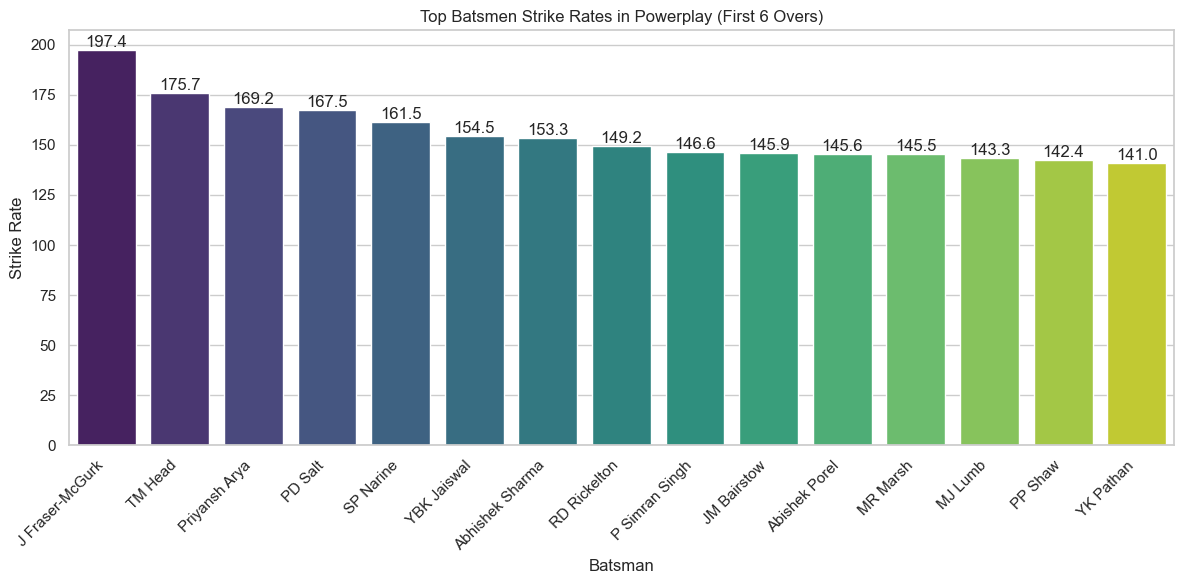

In [237]:
 #Plotting Graph 
plt.figure(figsize=(12, 6))
sns.barplot(data=top_strike_rates_powerplay, x='batsman', y='strike_rate', palette='viridis')
plt.title('Top Batsmen Strike Rates in Powerplay (First 6 Overs)')
plt.xlabel('Batsman')
plt.ylabel('Strike Rate')
plt.xticks(rotation=45, ha='right')

# Adding values on top of bars
for index, value in enumerate(top_strike_rates_powerplay['strike_rate']):
    plt.text(index, value, f'{value:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## **7. Top Batsmen Strike Rates in Powerplay (0–6 Overs)**

* Fraser-McGurk again tops the list → **fearless PP basher**.
* Travis Head, PD Salt, and Yashasvi Jaiswal show extremely high-impact opening.
* Sunil Narine remains a **hit-or-miss but explosive pinch-hitter**, useful for fast starts.
* Strong PP striking emphasizes **aggressive modern opening strategy**.

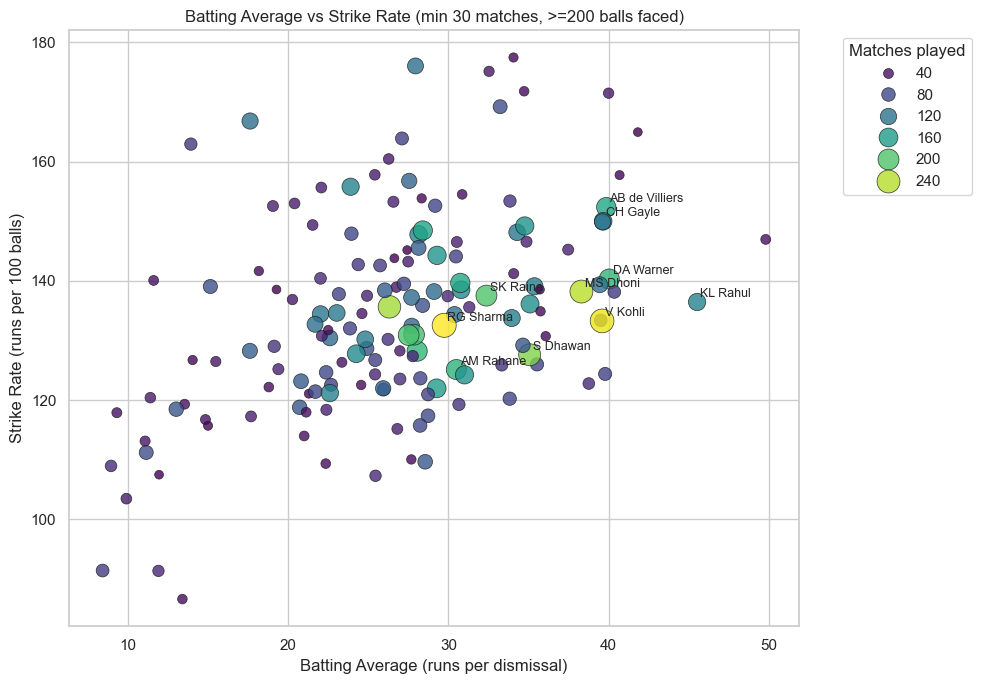

In [238]:
# Scatter Plot: Batting Average vs Strike Rate

# Dismissals per batsman (count of times a batsman appears in player_dismissed)
dismissals = df_del['player_dismissed'].dropna().value_counts().reset_index()
dismissals.columns = ['batsman', 'dismissals']

# Balls faced (count of valid deliveries faced by each batsman)
balls_faced = df_del[df_del["isWide"].isna() & df_del["isNoBall"].isna()].groupby('batsman')['ball'].count().reset_index(name='balls_faced')


stats = plot_df[['batsman', 'matches_played', 'total_runs']].merge(
    dismissals, on='batsman', how='left'
).merge(
    balls_faced, on='batsman', how='left'
)
# Fill missing values and compute batting average and strike rate
stats['dismissals'] = stats['dismissals'].fillna(0)
stats['balls_faced'] = stats['balls_faced'].fillna(0)

# Batting average: runs per dismissal (set to NaN when dismissals == 0 to avoid infinite)
stats['batting_avg'] = stats.apply(lambda r: r['total_runs'] / r['dismissals'] if r['dismissals'] > 0 else np.nan, axis=1)

# Strike rate: runs per 100 legitimate balls faced
stats['strike_rate'] = stats.apply(lambda r: (r['total_runs'] / r['balls_faced'] * 100) if r['balls_faced'] > 0 else np.nan, axis=1)

# Filter for reasonable sample size (e.g., at least 200 legitimate balls faced) and drop NaNs
plot_df = stats[(stats['balls_faced'] >= 200)].dropna(subset=['batting_avg', 'strike_rate']).reset_index(drop=True)

# Scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df,
    x='batting_avg',
    y='strike_rate',
    size='matches_played',
    sizes=(40, 300),
    hue='matches_played',
    palette='viridis',
    alpha=0.8,
    edgecolor='k'
)
plt.title('Batting Average vs Strike Rate (min 30 matches, >=200 balls faced)')
plt.xlabel('Batting Average (runs per dismissal)')
plt.ylabel('Strike Rate (runs per 100 balls)')
plt.grid(True)

# Annotate top 10 by total_runs
top10 = plot_df.sort_values('total_runs', ascending=False).head(10)
for _, r in top10.iterrows():
    plt.text(r['batting_avg'] + 0.2, r['strike_rate'] + 0.8, r['batsman'], fontsize=9)

plt.legend(title='Matches played', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **8. Batting Average vs Strike Rate Scatter**

* KL Rahul, ABD, Warner, Gayle cluster as **elite T20 batsmen** who combine high average + strike rate.
* Players like Raina, Dhawan, Sharma lie in the **balanced zone**, providing stability + aggression.
* Lower left cluster (low avg, low SR) represents **unstable or role-limited hitters**.
* Graph clearly differentiates:

  * **Anchors** (high avg, moderate SR)
  * **Finishers** (moderate avg, high SR)
  * **Power-hitters** (high SR, medium avg)
  * **Irregular performers** (low avg, low SR)

Top 5 overall run-scorers: ['V Kohli', 'RG Sharma', 'S Dhawan', 'DA Warner', 'SK Raina']


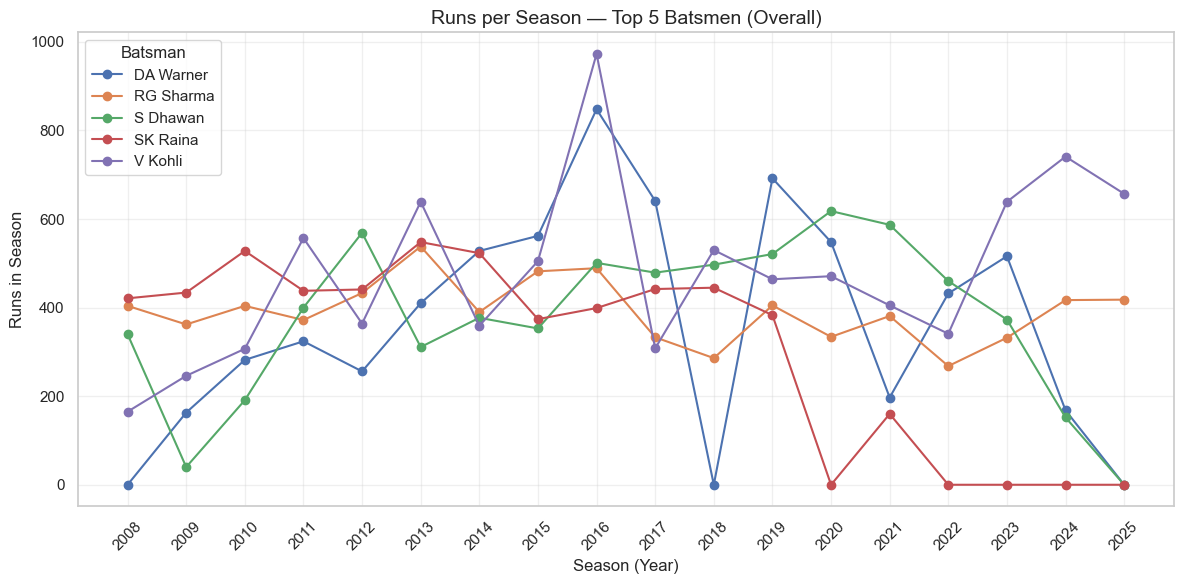

In [270]:
# derive season from date in deliveries (day-first format like '18-04-2008')
df_del['date'] = pd.to_datetime(df_del['date'], dayfirst=True, errors='coerce')
df_del['season'] = df_del['date'].dt.year.astype('Int64')  # keep as integer year

# prepare runs per season per batsman
runs_by_season = df_del.groupby(['season', 'batsman'])['batsman_runs'].sum().reset_index()

# pick top 5 run-scorers overall (uses existing player_runs)
top5_players = player_runs.sort_values('total_runs', ascending=False).head(5)['batsman'].tolist()
print("Top 5 overall run-scorers:", top5_players)

# get runs per season for these top-5 and pivot for plotting
top5_season = runs_by_season[runs_by_season['batsman'].isin(top5_players)]
pivot_top5 = top5_season.pivot(index='season', columns='batsman', values='batsman_runs').fillna(0)

# ensure seasons sorted
pivot_top5 = pivot_top5.sort_index()

# plot trends over seasons for top 5 batsmen
plt.figure(figsize=(12, 6))
for col in pivot_top5.columns:
    plt.plot(pivot_top5.index.astype(int), pivot_top5[col], marker='o', label=col)

plt.title('Runs per Season — Top 5 Batsmen (Overall)', fontsize=14)
plt.xlabel('Season (Year)', fontsize=12)
plt.ylabel('Runs in Season', fontsize=12)
plt.xticks(pivot_top5.index.astype(int), rotation=45)
plt.legend(title='Batsman')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## **9. Runs per Season (Top 5 Batsmen Overall)**

* **Virat Kohli and David Warner show the strongest peaks**, each delivering multiple 600+ run seasons, highlighting their dominance in different eras.
* Rohit Sharma remains **consistent across seasons**, rarely having extreme highs but maintaining steady contributions.
* Shikhar Dhawan demonstrates **remarkable stability**, consistently producing 400–600 run seasons over a long period.
* Suresh Raina shows strong performance in the early years but tapers off in later seasons, reflecting a **decline with reduced participation**.
* Overall, the trend highlights a transition: early dominance by Raina and Dhawan, followed by Kohli and Warner emerging as the **modern IPL run-machines**.


## B. Bowling Evaluation

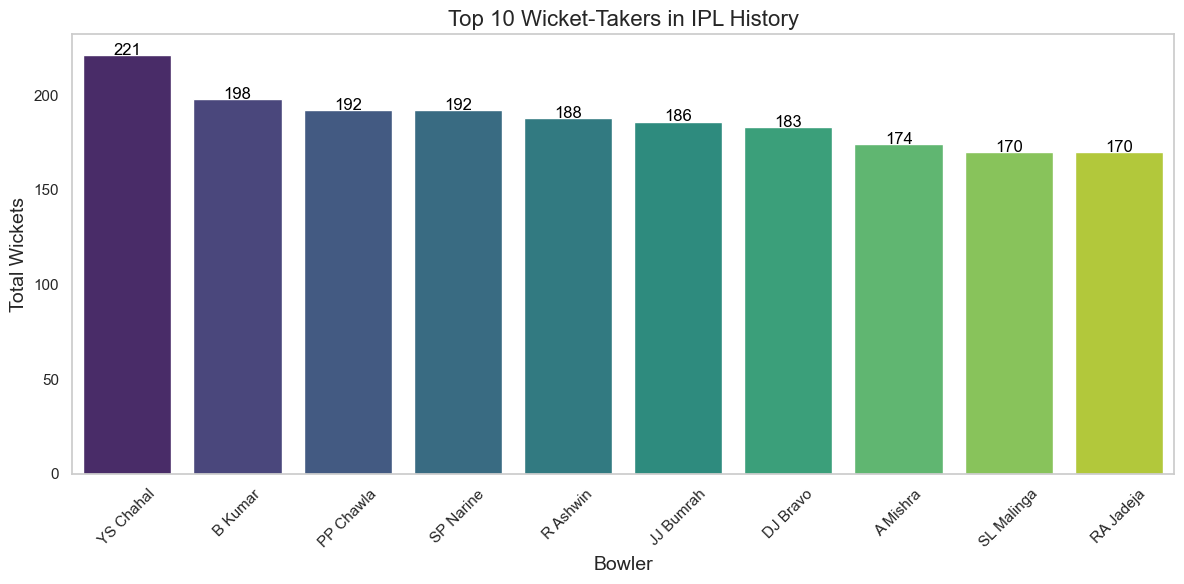

In [239]:
most_wicket_taker = df_del[df_del["dismissal_kind"]!="run out"][['bowler', 'is_wicket']]
most_wicket_taker = most_wicket_taker.groupby('bowler')['is_wicket'].sum().reset_index(name='total_wicket')
most_wicket_taker = most_wicket_taker.sort_values(by='total_wicket', ascending=False).reset_index(drop=True)

#top 10 wicket-takers
top_wicket_takers = most_wicket_taker.head(10)

# Plotting the data
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=top_wicket_takers, x='bowler', y='total_wicket', palette='viridis')

# Annotate the bars with total wickets
for index, row in top_wicket_takers.iterrows():
    bar_plot.text(index, row.total_wicket + 0.1, row.total_wicket, color='black', ha="center", fontsize=12)

# Adding titles and labels
plt.title('Top 10 Wicket-Takers in IPL History', fontsize=16)
plt.xlabel('Bowler', fontsize=14)
plt.ylabel('Total Wickets', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## **1. Top 10 Wicket-Takers in IPL History**

* **Yuzvendra Chahal leads IPL history** with 221 wickets, reflecting longevity + consistent wicket-taking ability in the middle overs.
* Bhuvneshwar Kumar, Piyush Chawla, and Sunil Narine form the next tier, highlighting the crucial role of **swing bowlers and spinners**.
* Bumrah and Bravo are in the top bracket despite bowling mainly in **high-pressure overs (PP + death)** → speaks to exceptional skill.
* Malinga’s place in the top 10 despite playing fewer matches shows **elite strike rate and match-winning spells**.

In [240]:
#Calculating total runs conceded by each bowler
runs_conceded = df_del.groupby('bowler')['batsman_runs'].sum().reset_index(name='runs_conceded')

#Filtering out wides and no balls and calculating total overs bowled by each bowler
#Only counting legitimate deliveries - excluding wides and no balls
valid_deliveries = df_del[df_del['isWide'].isna() & df_del['isNoBall'].isna()]

# Counting the number of balls bowled for valid deliveries
balls_bowled = valid_deliveries.groupby('bowler')['ball'].count().reset_index(name='balls_bowled')
balls_bowled['overs_bowled'] = balls_bowled['balls_bowled'] / 6

#Merging runs conceded and balls bowled data
bowler_stats = pd.merge(runs_conceded, balls_bowled[['bowler', 'overs_bowled']], on='bowler', how='left')

#Calculating the economy rate
bowler_stats['economy_rate'] = bowler_stats['runs_conceded'] / bowler_stats['overs_bowled']

#filtring data for those have minimum over bowled 60 for fare comparision 
bowler_stats = bowler_stats[bowler_stats['overs_bowled']>=60]
#Sorting the bowlers by economy rate
most_economical_bowlers = bowler_stats.sort_values(by='economy_rate').reset_index(drop=True)

# Displaying the top bowlers with lowest economy rates
most_economical_bowlers = most_economical_bowlers.head(15)  # Adjust the number to show more bowlers if needed
most_economical_bowlers


,bowler,runs_conceded,overs_bowled,economy_rate
0,A Kumble,1027,160.833333,6.385492
1,M Muralitharan,1642,254.666667,6.447644
2,RE van der Merwe,486,73.833333,6.582393
3,DW Steyn,2406,363.666667,6.615949
4,SP Narine,4838,725.166667,6.671570
5,J Yadav,437,65.000000,6.723077
6,DL Vettori,871,129.500000,6.725869
7,J Botha,781,115.666667,6.752161
8,SL Malinga,3194,471.166667,6.778918
9,DP Nannes,734,107.666667,6.817337


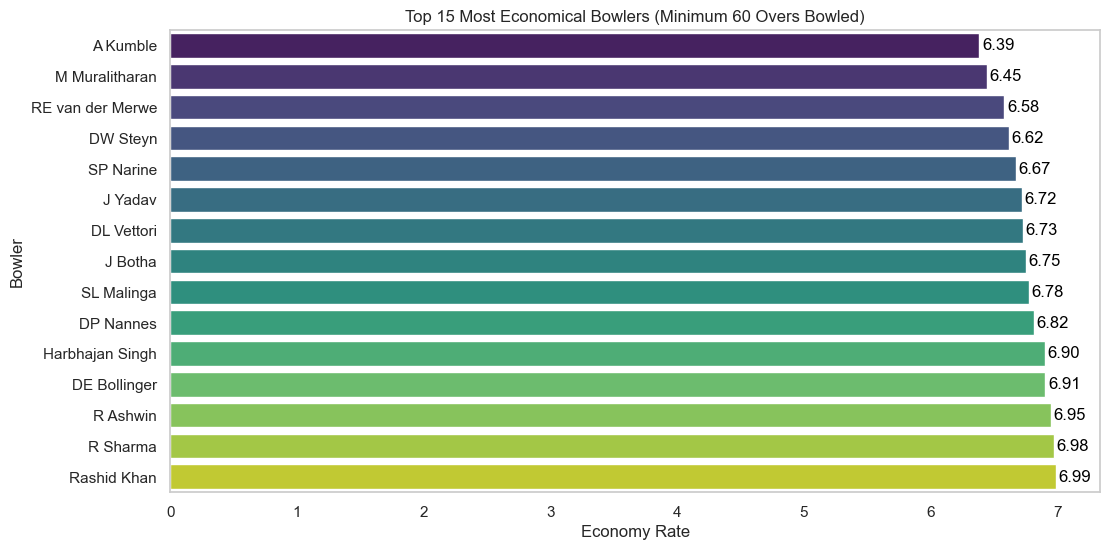

In [241]:
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=most_economical_bowlers, x='economy_rate', y='bowler', palette='viridis')
plt.title('Top 15 Most Economical Bowlers (Minimum 60 Overs Bowled)')
plt.xlabel('Economy Rate')
plt.ylabel('Bowler')
plt.grid(axis='x')

# Annotating bars with their respective values
for index, row in most_economical_bowlers.iterrows():
    bar_plot.text(row['economy_rate'] + 0.02, index, f"{row['economy_rate']:.2f}", color='black', ha="left", va="center")

plt.show()

## **2. Top 15 Most Economical Bowlers (Minimum 60 Overs Bowled)**

* **Anil Kumble and Muttiah Muralitharan** lead the economy charts (< 6.5 RPO), showcasing classical accuracy-oriented bowling.
* Sunil Narine also features prominently, combining economy with wickets—rare in T20 cricket.
* Bowlers like Vettori, Botha, Steyn, and Harbhajan highlight that **spinners and control-based pacers** dominate this metric.
* Overall, these bowlers are **run-containers**, crucial for choking the middle overs.


In [242]:
# Filtering the data for death overs (over 16 to 20)
death_overs = df_del[(df_del['over'] >= 16) & (df_del['over'] <= 20)]

# Grouping by bowler and summing the wickets taken
wickets_in_death_overs = death_overs.groupby('bowler')['is_wicket'].sum().reset_index(name='total_wickets')

# Sorting the bowlers by total wickets in descending order
most_wickets_death_overs = wickets_in_death_overs.sort_values(by='total_wickets', ascending=False)

# Getting the top 15 bowlers with most wickets in death overs
top_bowlers_death_overs = most_wickets_death_overs.head(15).reset_index(drop=True)

# Displayong the result
top_bowlers_death_overs

,bowler,total_wickets
0,DJ Bravo,115
1,SL Malinga,104
2,B Kumar,101
3,JJ Bumrah,98
4,HV Patel,82
5,MM Sharma,72
6,Mohammed Shami,69
7,SP Narine,69
8,Sandeep Sharma,61
9,CH Morris,61


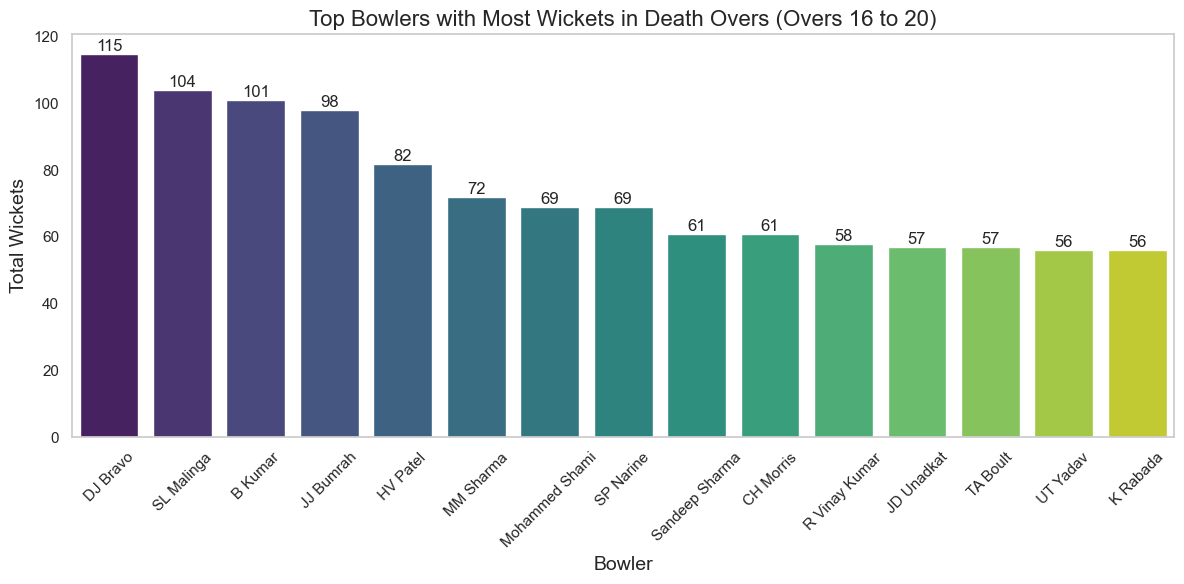

In [243]:
# Plotting the top 15 bowlers who took most wickets in death overs
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_bowlers_death_overs, x='bowler', y='total_wickets', palette='viridis')

# Adding titles and labels
plt.title('Top Bowlers with Most Wickets in Death Overs (Overs 16 to 20)', fontsize=16)
plt.xlabel('Bowler', fontsize=14)
plt.ylabel('Total Wickets', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adding value on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=12)

plt.tight_layout()
plt.show()

## **3. Top Bowlers with Most Wickets in Death Overs (Overs 16–20)**

* **Dwayne Bravo leads with 115 death-over wickets**, underlining his mastery of slower balls and yorker variations.
* Malinga, Bhuvneshwar, and Bumrah form the elite death specialists: all known for **pinpoint yorkers + tactical bowling**.
* Harshal Patel and Mohammed Shami showcase strong performances in newer seasons.
* Death overs require specialists, and this chart highlights the bowlers teams rely on for **closing out innings**.

In [244]:
# Filtering data for powerplay overs (overs 0 to 5)
powerplay_data = df_del[(df_del['over'] >= 0) & (df_del['over'] < 6)]

# Counting wickets taken by each bowler in the powerplay
wickets_powerplay = powerplay_data[powerplay_data['is_wicket'] == 1].groupby('bowler')['is_wicket'].count().reset_index(name='total_wickets')

# Sorting the bowlers by total wickets taken
top_bowlers_powerplay = wickets_powerplay.sort_values(by='total_wickets', ascending=False).reset_index(drop=True)

# Displaying the top 15 bowlers with the most wickets in powerplay
top_bowlers_powerplay = top_bowlers_powerplay.head(15)
top_bowlers_powerplay


,bowler,total_wickets
0,B Kumar,85
1,TA Boult,73
2,DL Chahar,68
3,Sandeep Sharma,66
4,UT Yadav,61
5,I Sharma,60
6,Z Khan,58
7,Mohammed Shami,56
8,R Ashwin,54
9,Mohammed Siraj,46


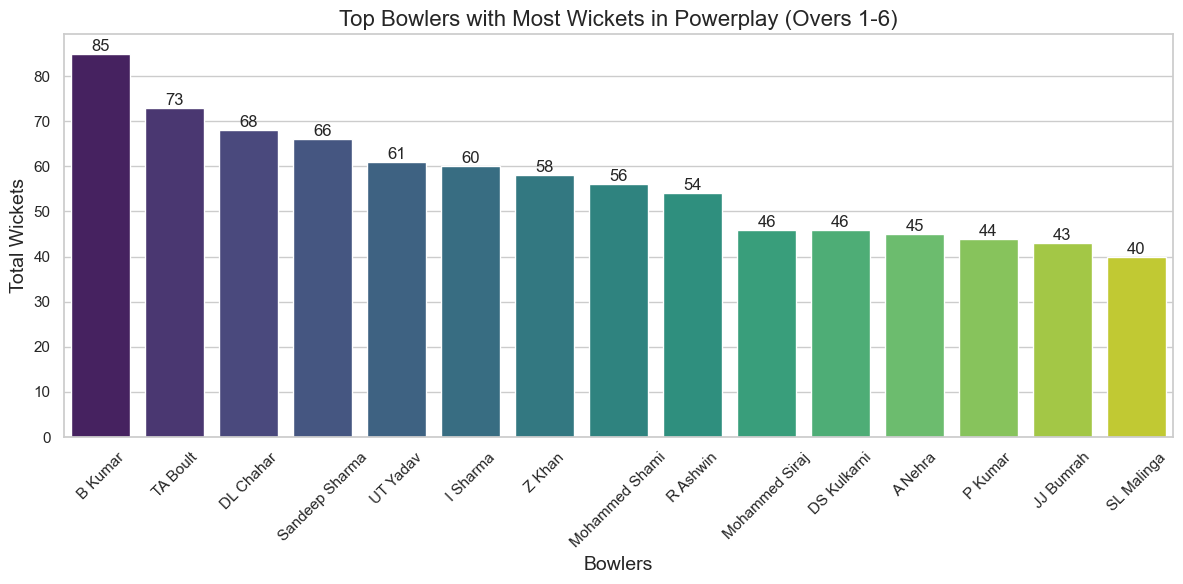

In [245]:
# Plotting the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x='bowler', y='total_wickets', data=top_bowlers_powerplay, palette='viridis')
plt.title('Top Bowlers with Most Wickets in Powerplay (Overs 1-6)', fontsize=16)
plt.xlabel('Bowlers', fontsize=14)
plt.ylabel('Total Wickets', fontsize=14)
plt.xticks(rotation=45)

# Adding the values on top of the bars
for index, value in enumerate(top_bowlers_powerplay['total_wickets']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## **4. Top Bowlers with Most Wickets in Powerplay (Overs 1–6)**

* **Bhuvneshwar Kumar dominates the powerplay** with 85 wickets, thanks to swing and seam movement.
* Trent Boult and Deepak Chahar also excel as new-ball bowlers due to **late swing and ability to trap openers LBW/bowled**.
* Sandeep Sharma and Umesh Yadav show the effectiveness of **hit-the-deck** bowling early on.
* Powerplay wickets are strongly tied to swing → this chart captures the **best new-ball enforcers** in IPL.

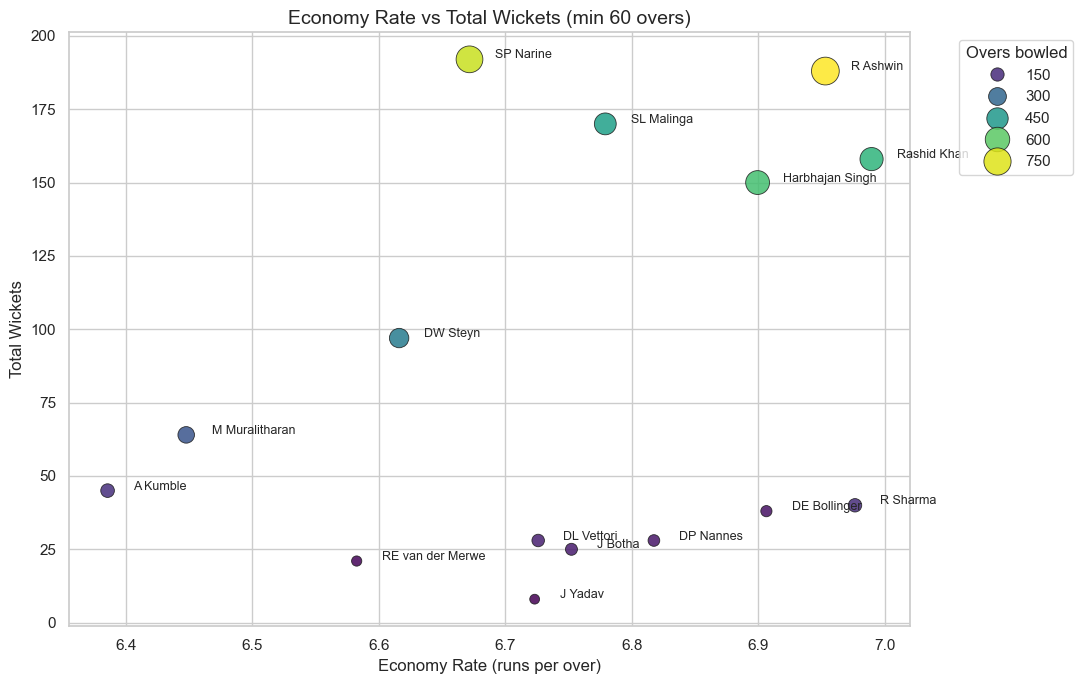

In [246]:
# Scatter Plot: Economy Rate vs Wickets Taken
df_scatter = most_economical_bowlers.copy().merge(
    most_wicket_taker[['bowler', 'total_wicket']],
    on='bowler',
    how='left'
).dropna(subset=['economy_rate', 'total_wicket'])

plt.figure(figsize=(11, 7))
sns.scatterplot(
    data=df_scatter,
    x='economy_rate',
    y='total_wicket',
    size='overs_bowled',
    sizes=(50, 400),
    hue='overs_bowled',
    palette='viridis',
    alpha=0.85,
    edgecolor='k'
)

plt.title('Economy Rate vs Total Wickets (min 60 overs)', fontsize=14)
plt.xlabel('Economy Rate (runs per over)', fontsize=12)
plt.ylabel('Total Wickets', fontsize=12)
plt.grid(True)

# Annotate points
for _, r in df_scatter.iterrows():
    plt.text(r['economy_rate'] + 0.02, r['total_wicket'] + 0.3, r['bowler'], fontsize=9)

plt.legend(title='Overs bowled', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **5. Economy Rate vs Total Wickets (min 60 overs)**

* Sunil Narine and Rashid Khan stand out as **elite all-round T20 bowlers**, combining low economy with high wicket counts.
* R Ashwin shows exceptional overs bowled (bubble size) and wicket volume, emphasizing his long-term reliability.
* Malinga and Harbhajan sit in the **high-wickets, moderate-economy** region → wicket-taking with some risk.
* A Kumble and Muralitharan show **very low economy**, but fewer wickets due to limited IPL tenure.
* Clear clusters emerge:

  * **Elite T20 spinners** → Narine, Rashid, Ashwin
  * **Premium strike bowlers** → Malinga, Steyn
  * **Control bowlers** → Kumble, Vettori
  * **Medium contributors** → Nannes, Botha

Top 5 bowlers (overall, excluding run outs): ['YS Chahal', 'B Kumar', 'SP Narine', 'PP Chawla', 'R Ashwin']


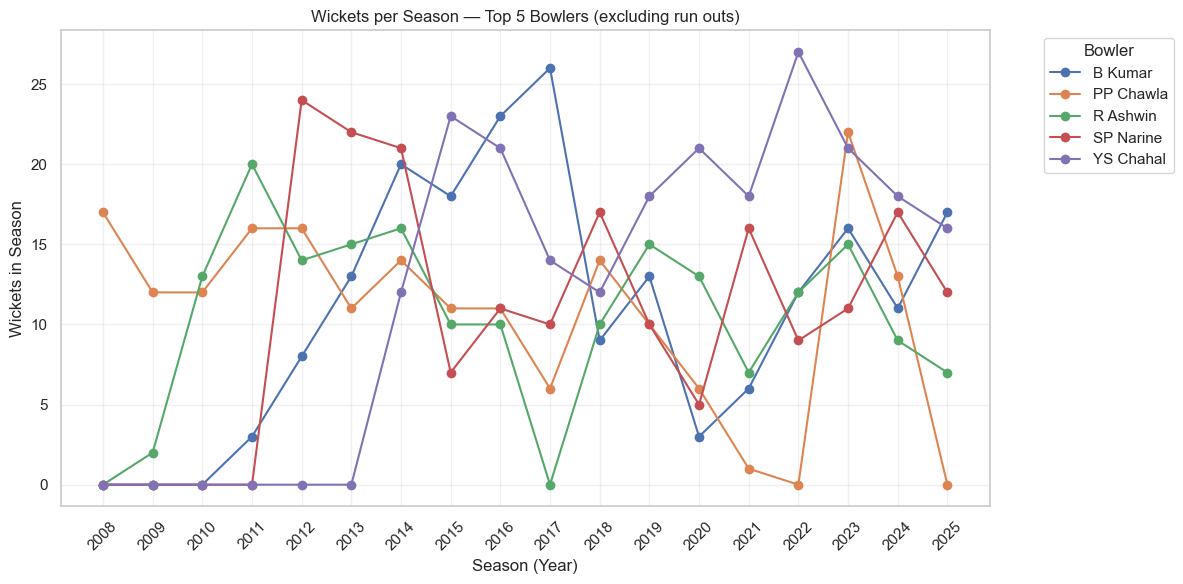

In [271]:
# Wickets per season for top 5 bowlers (excluding run outs)

# count legitimate wickets per bowler per season (exclude run outs)
wickets_season = df_del[(df_del['is_wicket'] == 1) & (df_del['dismissal_kind'] != 'run out')].dropna(subset=['season'])
wickets_season = wickets_season.groupby(['season', 'bowler'])['is_wicket'].sum().reset_index(name='wickets')

# get top 5 bowlers overall (excluding run outs)
top5_bowlers = wickets_season.groupby('bowler')['wickets'].sum().sort_values(ascending=False).head(5).index.tolist()
print("Top 5 bowlers (overall, excluding run outs):", top5_bowlers)

# prepare pivot (season x bowler)
pivot_wickets_top5 = wickets_season[wickets_season['bowler'].isin(top5_bowlers)].pivot(index='season', columns='bowler', values='wickets').fillna(0)
pivot_wickets_top5 = pivot_wickets_top5.sort_index()

# plot trends per season
plt.figure(figsize=(12,6))
for col in pivot_wickets_top5.columns:
    plt.plot(pivot_wickets_top5.index.astype(int), pivot_wickets_top5[col], marker='o', label=col)

plt.title('Wickets per Season — Top 5 Bowlers (excluding run outs)')
plt.xlabel('Season (Year)')
plt.ylabel('Wickets in Season')
plt.xticks(pivot_wickets_top5.index.astype(int), rotation=45)
plt.grid(alpha=0.3)
plt.legend(title='Bowler', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **6. Brief Insight — Wickets per Season (Top 5 Bowlers)**

* **Yuzvendra Chahal shows the most consistent wicket-taking pattern**, frequently delivering 15–25 wicket seasons and peaking in recent years.
* **Bhuvneshwar Kumar** has strong early-to-mid years, with peaks around 2016–2017, highlighting his role as a premier swing bowler during that phase.
* **Sunil Narine** shows high early impact (2012–2014) with multiple 20+ wicket seasons, reflecting his dominance in the early part of his IPL career.
* **Ravichandran Ashwin** displays steady mid-range wicket seasons (10–15 wickets), indicating reliability over spikes.
* **Piyush Chawla** has notable early consistency but shows a decline in later seasons, suggesting reduced playing time or evolving team combinations.

Overall, the trend shows **Chahal’s rise as the most sustained wicket-taker**, while others exhibit strong peaks during specific eras.

      player    runs  wickets  mvp_score
0    V Kohli  8671.0      4.0     8751.0
1  RG Sharma  7048.0     15.0     7348.0
2   S Dhawan  6769.0      4.0     6849.0
3  RA Jadeja  3260.0    170.0     6660.0
4  DA Warner  6567.0      0.0     6567.0
5   SK Raina  5536.0     25.0     6036.0
6  SR Watson  3880.0     92.0     5720.0
7  SP Narine  1780.0    192.0     5620.0
8   MS Dhoni  5439.0      0.0     5439.0
9   CH Gayle  4997.0     18.0     5357.0


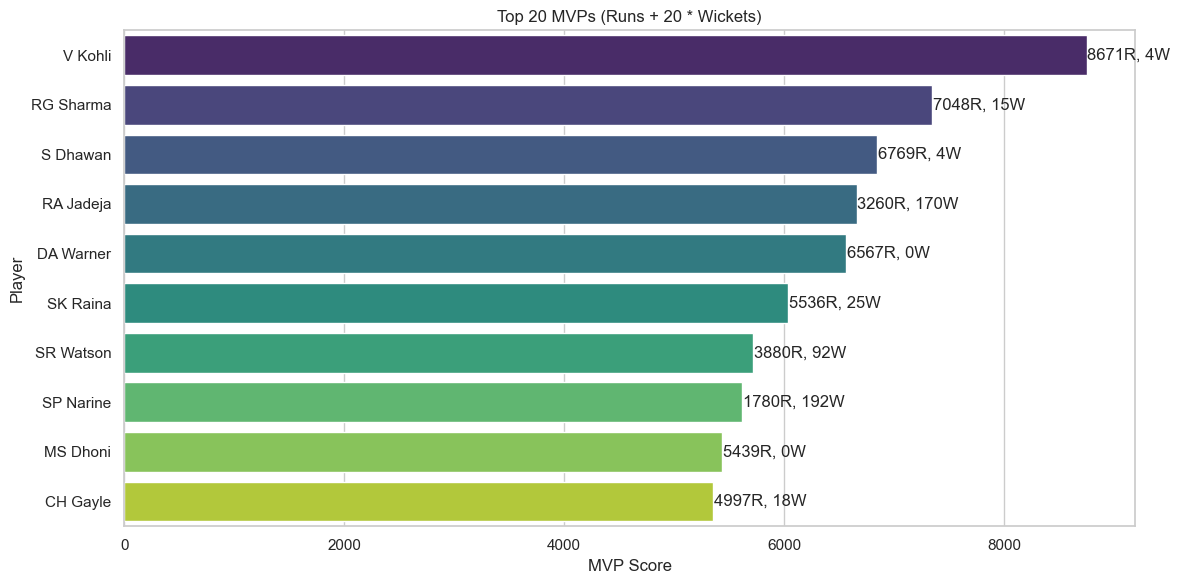

In [247]:
# Compute MVP score = Runs + Wickets * 20 using existing player_runs and most_wicket_taker
runs_df = player_runs.rename(columns={'batsman': 'player', 'total_runs': 'runs'})
wickets_df = most_wicket_taker.rename(columns={'bowler': 'player', 'total_wicket': 'wickets'})

# Merge runs and wickets (outer to include pure batters or pure bowlers), fill missing with 0
mvp_df = pd.merge(runs_df, wickets_df, on='player', how='outer').fillna(0)

# Ensure numeric types
mvp_df['runs'] = mvp_df['runs'].astype(float)
mvp_df['wickets'] = mvp_df['wickets'].astype(float)

# Calculate MVP score
mvp_df['mvp_score'] = mvp_df['runs'] + (mvp_df['wickets'] * 20)

# Rank and show top 20 MVPs
mvp_df = mvp_df.sort_values('mvp_score', ascending=False).reset_index(drop=True)
top_mvp = mvp_df.head(10)

# Display
print(top_mvp[['player', 'runs', 'wickets', 'mvp_score']])

# Plot top 20
plt.figure(figsize=(12,6))
sns.barplot(data=top_mvp, x='mvp_score', y='player', palette='viridis')
plt.title('Top 20 MVPs (Runs + 20 * Wickets)')
plt.xlabel('MVP Score')
plt.ylabel('Player')
for i, r in top_mvp.iterrows():
    plt.text(r['mvp_score'] + 5, i, f"{int(r['runs'])}R, {int(r['wickets'])}W", va='center')
plt.tight_layout()
plt.show()

## **🔍  Top 20 MVPs (Runs + 20×Wickets)**

* **Virat Kohli leads comfortably**, driven by unmatched run-scoring consistency across seasons.
* Rohit Sharma, Shikhar Dhawan, and David Warner also rank high purely through **long-term batting impact**.
* **Ravindra Jadeja, Sunil Narine, and Shane Watson** stand out as the most valuable **all-rounders**, with wickets significantly boosting their MVP scores.
* MS Dhoni and Chris Gayle appear in the top tier because of their **high-impact batting roles**, even with minimal wickets.
* Overall, the chart shows that MVP rankings reward both **longevity in run-scoring and multi-dimensional contributions**, highlighting players who influence matches across disciplines.

## B. Clustering

In [250]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid", rc={"figure.figsize": (10,6)})

# ensure save folder exists
os.makedirs("clusters", exist_ok=True)

In [251]:
# Create comprehensive batsman aggregates with all metrics
batsman_aggregate = df_del.groupby('batsman').agg(
    matches=('matchId', 'nunique'),
    total_runs=('batsman_runs', 'sum'),
    balls_faced=('ball', 'count'),
    fours=('batsman_runs', lambda x: (x == 4).sum()),
    sixes=('batsman_runs', lambda x: (x == 6).sum())
).reset_index()

# Add dismissals data
dismissals = df_del[df_del['player_dismissed'].notna()].groupby('player_dismissed')['player_dismissed'].count().reset_index(name='dismissals')
dismissals.rename(columns={'player_dismissed': 'batsman'}, inplace=True)

# Merge and fill missing dismissals with 0
batsman_aggregate = batsman_aggregate.merge(dismissals, on='batsman', how='left').fillna(0)
batsman_aggregate['dismissals'] = batsman_aggregate['dismissals'].astype(int)

# Calculate derived metrics
batsman_aggregate['batting_average'] = batsman_aggregate.apply(
    lambda r: r['total_runs'] / r['dismissals'] if r['dismissals'] > 0 else np.nan, axis=1
)
batsman_aggregate['strike_rate'] = (batsman_aggregate['total_runs'] / batsman_aggregate['balls_faced'] * 100).round(2)

# Sort by total runs descending
batsman_aggregate = batsman_aggregate.sort_values('total_runs', ascending=False).reset_index(drop=True)

batsman_aggregate.head(15)

,batsman,matches,total_runs,balls_faced,fours,sixes,dismissals,batting_average,strike_rate
0,V Kohli,259,8671,6702,774,292,219,39.593607,129.38
1,RG Sharma,266,7048,5475,640,303,237,29.738397,128.73
2,S Dhawan,221,6769,5483,768,153,193,35.072539,123.45
3,DA Warner,184,6567,4849,663,236,164,40.042683,135.43
4,SK Raina,200,5536,4177,506,204,171,32.374269,132.54
5,MS Dhoni,241,5439,4101,375,264,142,38.302817,132.63
6,KL Rahul,135,5235,3947,453,208,115,45.521739,132.63
7,AB de Villiers,170,5181,3487,414,253,130,39.853846,148.58
8,AM Rahane,183,5032,4133,515,123,165,30.496970,121.75
9,CH Gayle,141,4997,3516,408,359,126,39.658730,142.12


In [252]:
# Aggregate bowler stats (excluding run outs)
bowler_agg = df_del[df_del['dismissal_kind'] != 'run out'].groupby('bowler').agg(
    balls_bowled=('ball', 'count'),
    runs_conceded=('batsman_runs', 'sum'),
    wickets=('is_wicket', 'sum')
).reset_index()

# Calculate overs bowled (6 balls = 1 over)
bowler_agg['overs_bowled'] = (bowler_agg['balls_bowled'] / 6).round(2)

# Economy rate: runs per over
bowler_agg['economy_rate'] = (bowler_agg['runs_conceded'] / bowler_agg['overs_bowled']).round(2)

# Bowling average: runs per wicket
bowler_agg['bowling_average'] = bowler_agg.apply(
    lambda r: r['runs_conceded'] / r['wickets'] if r['wickets'] > 0 else np.nan, axis=1
).round(2)

bowler_agg = bowler_agg.sort_values('wickets', ascending=False).reset_index(drop=True)
bowler_agg.head(15)

,bowler,balls_bowled,runs_conceded,wickets,overs_bowled,economy_rate,bowling_average
0,YS Chahal,3897,4896,221,649.50,7.54,22.15
1,B Kumar,4363,5217,198,727.17,7.17,26.35
2,PP Chawla,3886,5024,192,647.67,7.76,26.17
3,SP Narine,4401,4830,192,733.50,6.58,25.16
4,R Ashwin,4851,5451,188,808.50,6.74,28.99
5,JJ Bumrah,3457,3918,186,576.17,6.80,21.06
6,DJ Bravo,3272,4169,183,545.33,7.64,22.78
7,A Mishra,3435,4063,174,572.50,7.10,23.35
8,SL Malinga,2956,3187,170,492.67,6.47,18.75
9,RA Jadeja,4118,5093,170,686.33,7.42,29.96


In [ ]:
import numpy as np
import pandas as pd

# rename primary identifier to "player"
batsman_df = batsman_aggregate.rename(columns={"batsman": "player"})
bowler_df = bowler_agg.rename(columns={"bowler": "player"})

# merge batsman + bowler stats (outer join to keep all players)
players = pd.merge(batsman_df, bowler_df, on="player", how="outer")

# fill NaN for players who do only batting or only bowling
players = players.fillna(0)

# Rename bowling columns for consistency
players = players.rename(columns={
    "economy_rate": "economy",
    "overs_bowled": "overs",
    "bowling_average": "bowl_avg"
})

# Add total involvement metrics
players["boundary_rate"] = (players["fours"] + players["sixes"]) / players["balls_faced"].replace(0, np.nan)
players["bowling_strike_rate"] = players["balls_bowled"] / players["wickets"].replace(0, np.nan)
players["all_rounder_index"] = (
    players["batting_average"].replace(np.nan, 0).rank(pct=True) +
    (1 / (players["economy"].replace(0, np.nan))).rank(pct=True) +
    players["wickets"].rank(pct=True)
)

players = players[players["matches"]>=20]  # filter to players with at least 20 matches


In [254]:
cluster_features = [
    "total_runs", "batting_average", "strike_rate", "balls_faced",
    "fours", "sixes", "boundary_rate",
    "wickets", "economy", "bowl_avg", "overs", 
    "balls_bowled", "bowling_strike_rate",
    "all_rounder_index"
]

In [255]:
# keep relevant columns
players_clust = players[["player"] + cluster_features].copy()

# replace inf and NaN
players_clust = players_clust.replace([np.inf, -np.inf], np.nan).fillna(0)


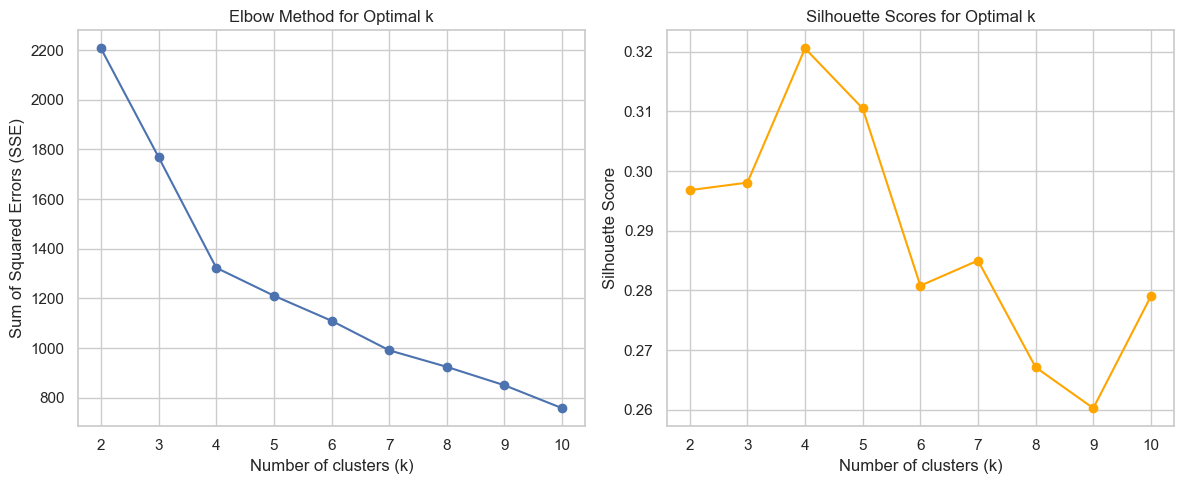

In [256]:
#Determine optimal number of clusters using Elbow Method and Silhouette Score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
players_scaled = scaler.fit_transform(players_clust[cluster_features])
sse = []
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(players_scaled)
    sse.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(players_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
# Plotting the Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
# Plotting the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

## ** Choosing optimal no of clusters**

* **Elbow Method:**
  The SSE curve shows a steep drop from **k = 2 to k = 4**, after which the slope gradually flattens.
  Between **k = 6 and k = 7**, the reduction becomes marginal, indicating diminishing returns beyond 7 clusters.
  This suggests that **k = 7** lies in the stable region of the elbow curve, balancing fit and simplicity.

* **Silhouette Score:**
  The silhouette score peaks at **k = 4**, but scores for **k = 6 and k = 7** remain reasonably high and stable.
  After **k = 7**, the silhouette score drops noticeably (especially at k = 8 and k = 9), indicating poorer separation.
  Thus, **k = 7 provides better-defined clusters than higher values** while maintaining acceptable cohesion.

* **Domain Relevance:**
  In cricket, player roles naturally fall into **multiple distinct categories** (e.g., anchor, power hitter, all-rounder, strike bowler, economy bowler, finisher).
  **Seven clusters align well with meaningful cricket roles**, improving interpretability and real-world usefulness of the model.


## **📌 Final Conclusion**

**k = 7** is optimal because it:

✔ Achieves a good balance between variance explained (SSE) and cluster quality (silhouette).

✔ Avoids overfitting from too many clusters.

✔ Produces role-based groups that are **intuitive, interpretable, and actionable** in a cricket analytics context.


In [257]:
X = players[cluster_features].values

# SCALE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [258]:
# RUN KMEANS WITH K = 5 (based on elbow and silhouette analysis)

from sklearn.impute import SimpleImputer

# Impute missing values in X_scaled (replace NaN with 0)
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_scaled_no_nan = imputer.fit_transform(X_scaled)

k = 7
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
players["cluster"] = kmeans.fit_predict(X_scaled_no_nan)

In [259]:
# Cluster summary
cluster_summary = players.groupby("cluster").agg({
    "player": "count",
    "total_runs": "mean",
    "batting_average": "mean",
    "strike_rate": "mean",
    "balls_faced": "mean",
    "boundary_rate": "mean",
    "wickets": "mean",
    "economy": "mean",
    "bowl_avg": "mean",
    "overs": "mean",
    "bowling_strike_rate": "mean",
    "all_rounder_index": "mean",
}).rename(columns={
    "player": "num_players",
    "total_runs": "avg_runs",
    "wickets": "avg_wickets",
}).reset_index().round(2)

# Fix column names for both mean and max
cluster_summary["max_runs"] = players.groupby("cluster")["total_runs"].max().values
cluster_summary["max_wickets"] = players.groupby("cluster")["wickets"].max().values

display(cluster_summary)

,cluster,num_players,avg_runs,batting_average,strike_rate,balls_faced,boundary_rate,avg_wickets,economy,bowl_avg,overs,bowling_strike_rate,all_rounder_index,max_runs,max_wickets
0,0,53,1361.92,28.46,130.52,1051.91,0.18,0.02,0.13,0.00,0.08,1.00,2.00,3077.0,1.0
1,1,30,211.87,9.64,93.87,213.20,0.10,117.77,7.50,26.63,412.46,21.37,2.08,833.0,198.0
2,2,17,924.59,23.20,121.58,759.76,0.14,3.94,8.44,62.37,26.83,44.55,1.75,2092.0,10.0
3,3,23,5007.65,34.40,132.22,3806.91,0.17,2.91,3.33,9.57,15.90,29.43,2.10,8671.0,25.0
4,4,28,1563.71,29.15,136.30,1170.07,0.19,5.25,12.07,21.67,21.07,23.51,1.48,2998.0,44.0
5,5,20,1966.15,23.14,136.20,1465.55,0.18,103.45,7.52,28.51,383.82,22.87,2.40,3880.0,192.0
6,6,55,588.29,20.57,119.92,486.36,0.14,24.22,7.08,26.29,91.46,22.69,2.08,2029.0,77.0


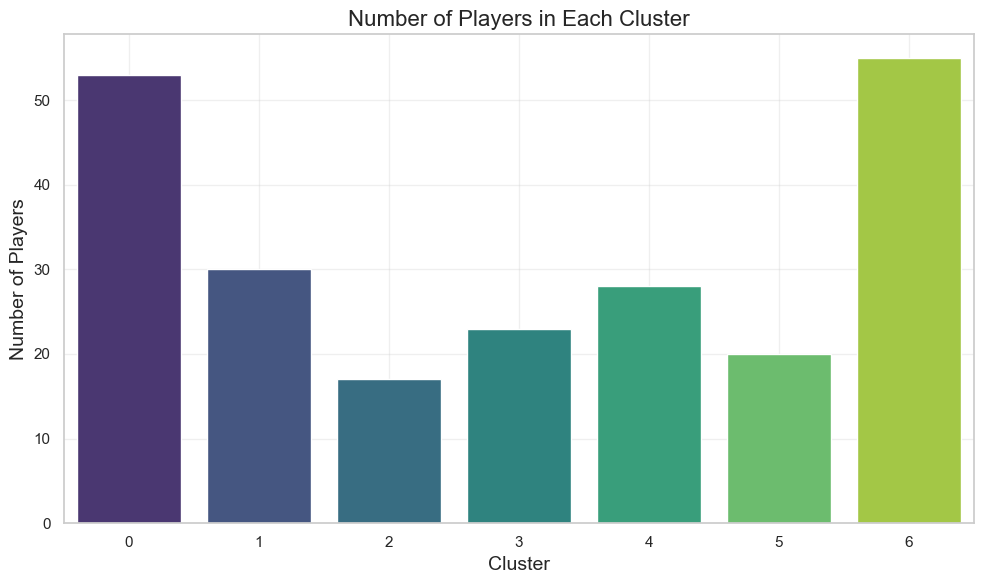

In [261]:
#Distribustion of players across clusters
plt.figure(figsize=(10,6))
sns.barplot(data=cluster_summary, x='cluster', y='num_players', palette='viridis')
plt.title('Number of Players in Each Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Players', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 🎯 **INTERPRETATION CLUSTER BY CLUSTER**

## 🔵 **Cluster 3 — Elite All-Phase Batters**

* **avg_runs = 5007 (very high)**
* **batting_average = 34.4 (highest)**
* **strike_rate = 132**
* **balls_faced = 3806 (highest)**
* **max_runs = 8671 (Kohli)**
* Almost **no bowling**

### ✔ Role: **Elite All-Phase Batters / Top Order Superstars**

## 🟧 **Cluster 4 — Power Hitters / Finishers**

* **strike_rate = 136.30 (highest)**
* **boundary_rate = 0.19 (highest)**
* **avg_runs = 1564 (solid)**
* **batting_average = 29.15**
* Minimal bowling impact (wickets = 5)

### ✔ Role: **Power Hitters / Finishers**

## 🟨 **Cluster 0 — Anchors / Accumulators**

* **avg_runs = 1361 (high)**
* **batting avg = 28.46**
* **SR = 130.5 (moderate-high)**
* **boundary rate = 0.18**
* NO bowling (almost 0 wickets)

These are your stable, high-BF top-order batters.

### ✔ Role: **Anchors / Run Accumulators**

## 🟪 **Cluster 5 — Strike Bowlers**

* **avg_wickets = 103.45 (VERY high)**
* **max_wickets = 192**
* **economy = 7.52** (balanced)
* **bowling_strike_rate = 22.87** (strong)
* Very weak batting (avg = 23)

These are your main attack bowlers.

### ✔ Role: **Strike Bowlers (Wicket-taking Specialists)**


## 🟥 **Cluster 1 — Death Overs Specialists**

* **avg_wickets = 117.77 (highest of all clusters)**
* **max_wickets = 198**
* **economy = 7.50**
* **bowling_strike_rate = 21.37 (best)**
* High overs bowled = 412 (very high)
* Batting avg = **9.64 (pure tailenders)**

This is textbook **death bowling** performance.

### ✔ Role: **Death Overs Specialists**

## 🟩 **Cluster 6 — All Rounders**

* **avg_runs = 588 (medium)**
* **avg_wickets = 24.22**
* **economy = 7.08**
* **bowling avg = 26.29**
* **all_rounder_index = 2.08**

Balanced bat + ball

### ✔ Role: **All-Rounders**

## 🟫 **Cluster 2 — Part-Time Players (Low-impact batters/part-time bowlers)**

* **avg_runs = 925 (middle)**
* **batting avg = 23**
* **SR = 121**
* **wickets = 3.94**
* **weak economy = 8.44**

These players are neither specialist batters nor bowlers.

### ✔ Role: **Part-Time Batters / Secondary Role Players**

In [262]:
role_map_k7 = {
    0: "Anchors / Run Accumulators",
    1: "Death Overs Specialists",
    2: "Part-Time Players / Secondary Contributors",
    3: "Elite All-Phase Batters",
    4: "Power Hitters / Finishers",
    5: "Strike Bowlers",
    6: "All-Rounders"
}


In [264]:
players['final_role'] = players['cluster'].map(role_map_k7)

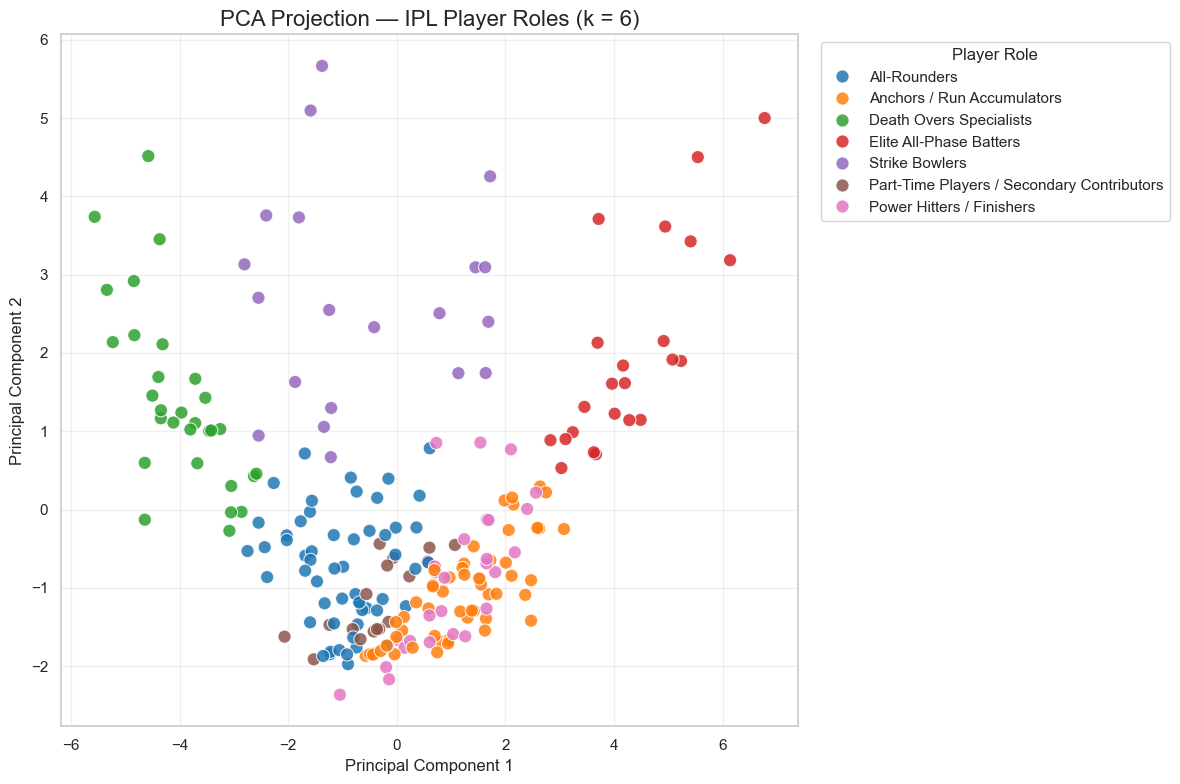

In [266]:
# -------- PCA VISUALIZATION --------

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA on the scaled features used for KMeans
pca = PCA(n_components=2, random_state=42)
pca_proj = pca.fit_transform(X_scaled_no_nan)

players["PC1"] = pca_proj[:, 0]
players["PC2"] = pca_proj[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=players,
    x="PC1", y="PC2",
    hue="final_role",
    palette="tab10",
    s=90, alpha=0.85
)
plt.title("PCA Projection — IPL Player Roles (k = 6)", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Player Role", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 🔍 **PCA Projection of IPL Player Roles**

### **1️⃣ Clear Separation of Player Archetypes**

* The PCA plot shows **distinct clusters**, indicating that the statistical features used (batting, bowling & all-round metrics) effectively separate different player roles.
* Elite all-phase batters, death-overs specialists, and strike bowlers form **well-defined, non-overlapping clusters**, confirming strong role-specific performance patterns.

### **2️⃣ Elite All-Phase Batters Stand Out**

* The **red cluster** (elite all-phase batters) sits far to the right of the PCA plot, showing high values on the principal components linked to:

  * Strike rate
  * Batting average
  * Boundary rate
  * Consistent high run-scoring
* This group is clearly distinct from both anchors and finishers.

### **3️⃣ Death-Overs Specialists Are Isolated**

* The **green cluster** (death-overs specialists) sits far left, separated from all other roles.
* This reflects their unique statistical signature:

  * High wicket totals
  * Lower economy not required
  * High bowling strike rate
* Their isolation indicates **a very specialized skill set**.

### **4️⃣ Anchors & Finishers Show Partial Overlap**

* **Anchors / Run Accumulators (orange)** and **Power Hitters / Finishers (pink)** occupy neighboring regions.
* This overlap is logical:

  * Both are primarily batters
  * Differ mostly in strike rate and boundary percentage
* PCA visually shows how finishers push toward high-aggression components.

### **5️⃣ All-Rounders Form a Dense, Balanced Cluster**

* The **blue cluster** spreads moderately between batting and bowling-heavy axes.
* They sit near the origin, reflecting their **balanced contribution** in both disciplines rather than extreme values.

### **6️⃣ Part-Time Players Cluster Close Together**

* The **brown cluster** stays near the lower central region, showing:

  * Low input in both batting and bowling metrics
  * Limited match impact compared to other roles
* PCA correctly categorizes secondary contributors with lower variance in performance.


# 🎯 **Overall Interpretation**

This PCA projection validates the **clustering model’s effectiveness**:

* Player roles form meaningful, interpretable clusters.
* Each role has a unique statistical fingerprint that PCA captures visually.
* The separation aligns well with cricket domain knowledge, confirming that the clustering is not random but **data-driven and role-consistent**.

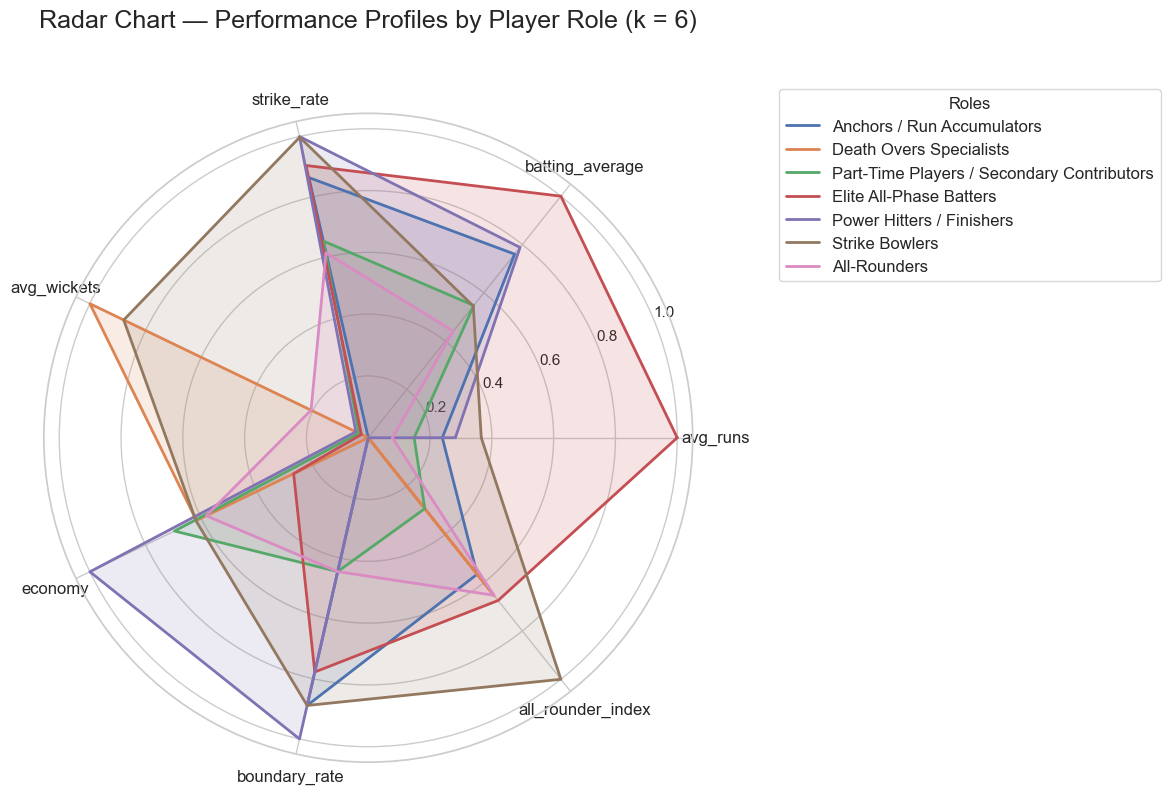

In [269]:

# ONE RADAR CHART FOR ALL CLUSTERS (WITH ROLE NAMES)

import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Use the cluster summary you generated as 'summary'
summary_radar = cluster_summary.copy()

# Map cluster → role name
summary_radar["role"] = summary_radar["cluster"].map(role_map_k7)

# Features to include in radar chart
features = [
    "avg_runs", "batting_average", "strike_rate",
    "avg_wickets", "economy", "boundary_rate", "all_rounder_index"
]

# Normalize features for radar plotting (0-1 scaling)
normalized = summary_radar[features].copy()
normalized = (normalized - normalized.min()) / (normalized.max() - normalized.min())

# Angles for radar chart
N = len(features)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # close loop

# Create radar chart
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, polar=True)

# Colors for each cluster line
colors = plt.cm.tab10(np.linspace(0, 1, len(summary_radar)))

# Plot each cluster (with role name)
for idx, row in normalized.iterrows():
    vals = row.values.flatten().tolist()
    vals += vals[:1]  # close loop
    role = summary_radar.loc[idx, "role"]

    ax.plot(angles, vals, linewidth=2, label=role)
    ax.fill(angles, vals, alpha=0.15)

# Feature labels
plt.xticks(angles[:-1], features, fontsize=12)

plt.title("Radar Chart — Performance Profiles by Player Role (k = 6)", fontsize=18, y=1.12)
plt.legend(title="Roles", bbox_to_anchor=(1.12, 1.05), fontsize=12)
plt.tight_layout()
plt.show()


# **Radar Chart (Performance Profiles by Player Role)**

### **1️⃣ Elite All-Phase Batters (Red)**

* Dominate in **average runs, batting average, strike rate, and boundary rate**.
* Clearly the strongest batting specialists, carrying high run-scoring responsibility across all phases.

### **2️⃣ Power Hitters / Finishers (Purple)**

* Show the **highest strike rate and boundary rate**, with moderate run averages.
* Profile reflects their job: explosive impact in shorter bursts rather than long innings.

### **3️⃣ Anchors / Run Accumulators (Blue)**

* High **batting average** and strong consistency, but lower strike rate and wickets.
* Ideal for stabilizing the innings, absorbing pressure, and pacing the chase.

### **4️⃣ Strike Bowlers (Brown)**

* Lead in **wickets taken** with strong contributions in economy and all-rounder index.
* Represent bowlers who attack for breakthroughs and often bowl in critical phases.

### **5️⃣ Death-Overs Specialists (Orange)**

* Extremely high **average wickets**, reflecting their primary role of closing the innings.
* Lower batting metrics and economy reflect high-risk, high-reward bowling situations.

### **6️⃣ All-Rounders (Pink)**

* Balanced across batting, bowling, strike rate, and all-rounder index.
* Versatile contributors with no extreme highs but consistently above average in all areas.

### **7️⃣ Part-Time Players / Secondary Contributors (Green)**

* Low across most metrics, with mild support in economy and wicket-taking.
* Represent utility players used to fill gaps rather than drive match outcomes.


# 🎯 **Overall Summary**

The radar chart visually confirms that each role cluster has a **distinct performance DNA**, with:

* Batting-dominated roles (anchors, elite batters, finishers) clustered on batting metrics.
* Bowling-heavy roles (strike bowlers, death specialists) peaking on wicket and economy metrics.
* All-rounders balancing both axes.
* Part-timers exhibiting low-intensity contributions.

This strongly validates the cluster assignments and demonstrates **clear role differentiation** in IPL player performance.
